In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [3]:
years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018, 2020, 2021, 2024]

In [4]:
def prepare_data(year):

    if year != 2024:
        data = pd.read_csv('./Federal_Elections_Data/'+str(y)+'.csv')
    else:
        # data = pd.read_csv('./Federal_Elections_Data/2024_update.tsv', sep = '\t') #full data, including e-voting
        data = pd.read_csv('./Federal_Elections_Data/2024.tsv', sep = '\t') #97% protocols processed, without e-voting

    if 'Число действительных избирательных бюллетеней' in data.columns:
        try:
            data['total_voters'] = data['Число действительных избирательных бюллетеней'] + data['Число недействительных избирательных бюллетеней']
            data['invalid_votes'] = data['Число недействительных избирательных бюллетеней']
        except:
            try:
                data['total_voters'] = data['Число действительных избирательных бюллетеней'] + data['Общее число недействительных избирательных бюллетеней']
                data['invalid_votes'] = data['Общее число недействительных избирательных бюллетеней']
            except:
                data['total_voters'] = data['Число действительных избирательных бюллетеней'] + data['Число недействительных избирательных бюллетеней']
                data['invalid_voters'] = data['Число недействительных избирательных бюллетеней']

    elif 'Число действительных бюллетеней' in data.columns:
        data['total_voters'] = data['Число действительных бюллетеней'] + data['Число недействительных бюллетеней']
        data['invalid_votes'] = data['Число недействительных бюллетеней']
    else:
        try:
            data['total_voters'] = data['Число бюллетеней, содержащихся в ящиках для голосования']
            data['invalid_votes'] = data['Число недействительных бюллетеней']
        except:
            print(data.columns)
            data['total_voters'] = data['Число действительных избирательных бюллетеней'] + data['Число недействительных избирательных бюллетеней']
            data['invalid_voters'] = data['Число недействительных избирательных бюллетеней']

    data['turnout'] = data['total_voters']/data['total_citizens']
    data['result_leader'] = data['leader']/data['total_voters']
    data['result_other'] = (data['total_voters'] - data['leader'])/data['total_voters']
    
    return data

In [5]:
data_years = []
for y in years:
    data_years.append(prepare_data(y))
    print(len(data_years[-1]))

91333
95205
95779
96193
96612
95225
95415
96871
97699
96765
96325
93542


In [6]:
data_years[-1]

region          tik       uik  \
0         Алтайский край     Алейская  УИК №554   
1         Алтайский край     Алейская  УИК №555   
2         Алтайский край     Алейская  УИК №556   
3         Алтайский край     Алейская  УИК №557   
4         Алтайский край     Алейская  УИК №558   
...                  ...          ...       ...   
93537  город Севастополь  Нахимовская  УИК №186   
93538  город Севастополь  Нахимовская  УИК №187   
93539  город Севастополь  Нахимовская  УИК №188   
93540  город Севастополь  Нахимовская  УИК №189   
93541  город Севастополь  Нахимовская  УИК №190   

       Число избирателей, включенных в список избирателей  \
0                                                  526.0    
1                                                  155.0    
2                                                  381.0    
3                                                  109.0    
4                                                  112.0    
...                                                  ...    
93537                                             1347.0    
93538                                             2193.0    
93539                                             1491.0    
93540                                             1202.0    
93541                                             1192.0    

       Число избирательных бюллетеней, полученных участковой избирательной комиссией  \
0                                                  550.0                               
1                                                  150.0                               
2                                                  400.0                               
3                                                  100.0                               
4                                                  100.0                               
...                                                  ...                               
93537                                             1300.0                               
93538                                             2400.0                               
93539                                             1400.0                               
93540                                             1100.0                               
93541                                             1100.0                               

       Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно  \
0                                                    0.0                                
1                                                    0.0                                
2                                                    0.0                                
3                                                    0.0                                
4                                                    0.0                                
...                                                  ...                                
93537                                                0.0                                
93538                                                0.0                                
93539                                                0.0                                
93540                                                0.0                                
93541                                                0.0                                

       Число избирательных бюллетеней, выданных в помещении для голосования в день голосования  \
0                                                  199.0                                         
1                                                   85.0                                         
2                                                  185.0                                         
3                                                   46.0                                         
4                                                   68.0

In [7]:
data_years_filtered = []
for y in years:
    d = prepare_data(y)
    data_years_filtered.append(d[d['total_citizens']>100]) #exclude stations with < 100 citizens
    # data_years_filtered.append(d[d['total_citizens']>500])
    print(len(data_years_filtered[-1]))

86940
90185
90682
91206
91588
90997
91042
92720
93523
92486
92063
88103


In [8]:
data = data_years_filtered[-1]

# Shpilkin method

In [9]:
percents = np.linspace(0,1,101)

In [10]:
def get_shpilkin_plot(data_r, column = 'turnout'):

    n_leader = []
    n_other = []
    std_other = []
    std_leader = []
    for p in range(100):
        data_p = data_r[data_r[column]>percents[p]][data_r[column]<=percents[p+1]]
        n_leader.append(sum(data_p['leader']))
        n_other.append(sum(data_p['total_voters']) - sum(data_p['leader']))
        if len(data_p)>0:
            std_other.append(np.std(np.array(data_p['total_voters']) - np.array(data_p['leader'])))
            std_leader.append(np.std(np.array(data_p['leader'])))
        else:
            std_other.append(0)
            std_leader.append(0)

    return np.array(n_leader), np.array(n_other), np.array(std_leader), np.array(std_other)

In [11]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [12]:
from scipy.optimize import curve_fit

In [13]:
def fit_bimodal(x, y, mu1, max1):
    expected=(mu1,.1,max1,mu1+(1-mu1)/2,.01,y[int(mu1*100+(1-mu1)/2*100)])
    params,cov=curve_fit(bimodal,x[:-3],y[:-3],expected)
    if params[0]<params[3]:
        indmax = int((params[0]-params[1])*100) + np.argmax(y[int((params[0]-params[1])*100):int((params[0]+params[1])*100)])
    else:
        indmax = int((params[3]-params[4])*100) + np.argmax(y[int((params[3]-params[4])*100):int((params[3]+params[4])*100)])
    return bimodal(x,*params), indmax

In [14]:
def get_true_leader_votes(n_leader, n_other, indmax):
    coeff = n_leader[indmax]/n_other[indmax]
    true_leader = n_other*coeff
    return true_leader, coeff

In [15]:
def smooth(y, box_pts = 5):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[-2:] = y[-2:]
    return y_smooth

In [16]:
regions = sorted(list(set(data_years_filtered[-2]['region'])))

## Regional

In [64]:
def plot_region_year(r, y):

    i = years.index(y)

    print(y)

    d = data_years_filtered[i]
    
    data_r = d[d['region']==r]
    print(r, sum(data_r['total_citizens']))

    n_leader, n_other, std_leader, std_other = get_shpilkin_plot(data_r)

    try:
        gauss_y, indmax = fit_bimodal(percents[1:], smooth(n_other), np.argmax(smooth(n_other))/100, max(smooth(n_other)))
    except:
        gauss_y = []

    plt.figure(figsize = [5,3])
    plt.plot(percents[1:], n_leader, alpha = 0.7)
    plt.plot(percents[1:], n_other, alpha = 0.7)
    
    if len(gauss_y)>0:
        # plt.plot(percents[1:], gauss_y, alpha = 0.7, c = 'red')
        pass
    else:
        indmax = np.argmax(n_other[:-3])

    if np.mod(indmax,10)==0:
        indmax += 1
    elif indmax == 9:
        indmax -= 1

    true_leader, coeff = get_true_leader_votes(n_leader, n_other, indmax)

    df = pd.DataFrame({'bins': np.linspace(0,100,101)[:-1],
                      'n_leader': n_leader,
                      'n_other': n_other,
                      'n_leader_corrected': true_leader})
    # df.to_csv('./shpilkin_plots_by_region/'+r+'_'+str(y)+'.csv', index = False)

    sumsqrt = []
    for j in range(100):
        s = 0
        if n_other[j]>0:
            s += (std_other[j]/n_other[j])**2
        if n_leader[indmax]>0:
            s += (std_leader[indmax]/n_leader[indmax])**2
        sumsqrt.append(s)
    
    deltas = true_leader*np.sqrt(np.array(sumsqrt))

    plt.plot(percents[1:], true_leader, alpha = 0.7)
    plt.fill_between(percents[1:], true_leader-2*deltas, true_leader+2*deltas, color = 'green', alpha = 0.2)
    plt.fill_between(percents[1:], n_leader-2*std_leader, n_leader+2*std_leader, color = 'blue', alpha = 0.2)
    plt.show()

    d_full = data_years_filtered[i]
    
    plt.figure(figsize = [5,3])

    df = pd.DataFrame({'turnout': data_r['turnout'],
                      'result_leader': data_r['result_leader']})
    df.to_csv('region_scatter.csv', index = False)
    
    plt.scatter(data_r['turnout'], data_r['result_leader'], s = 1, alpha = 0.3)#, color = 'red')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

    # n_votes.append(sum(n_leader) - sum(true_leader))
    # n_percents.append(sum(n_leader)/(sum(n_leader)+sum(n_other)) - sum(true_leader)/(sum(true_leader)+sum(n_other)))
    # n_percents_leader.append((sum(n_other)-sum(true_leader))/sum(n_leader))

**Note**: For some regions and years, the corrrected result may be higher than official, giving negative amount of falsifications. It indicates either inapplicability of the Shpilkin method (e.g. low population in the region, or low number of "fair" stations), or statistical error

2024
Алтайский край 1469272.0


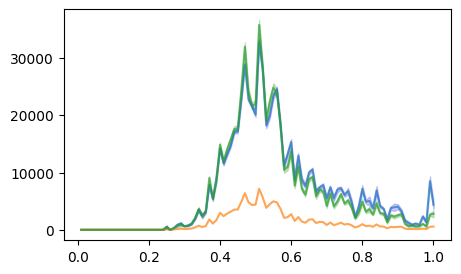

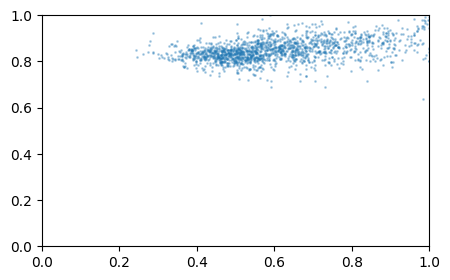

2024
Амурская область 589076.0


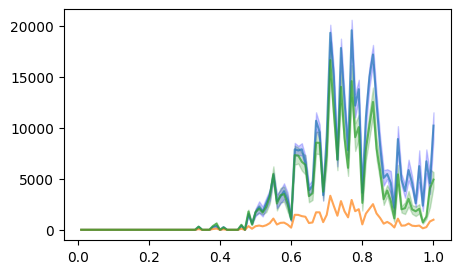

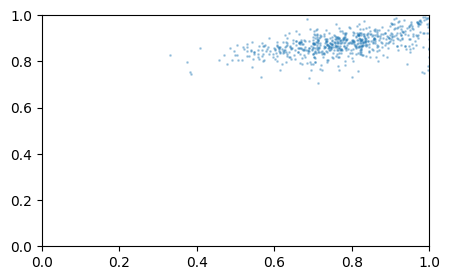

2024
Архангельская область 740515.0


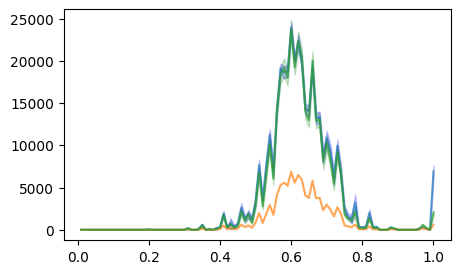

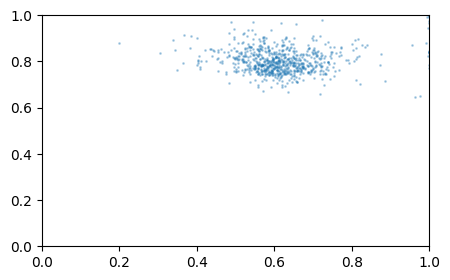

2024
Астраханская область 703596.0


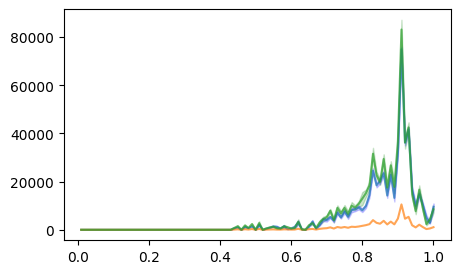

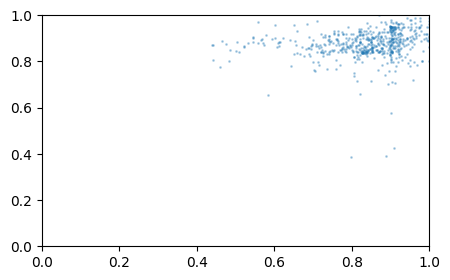

2024
Белгородская область 1048749.0


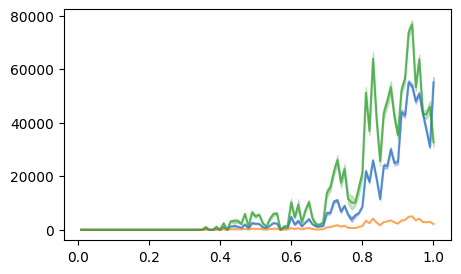

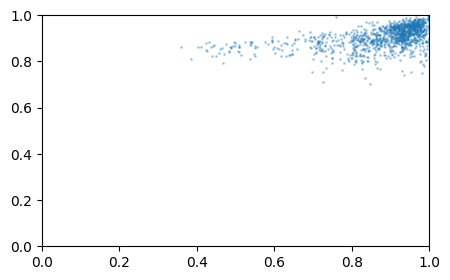

2024
Брянская область 941249.0


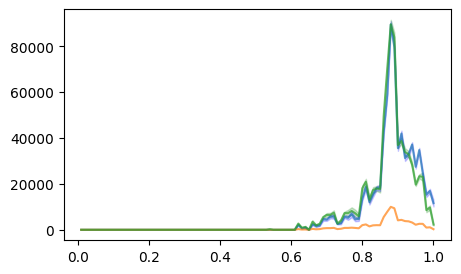

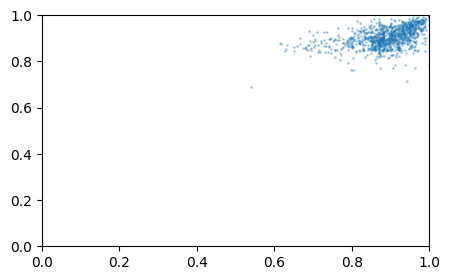

2024
Владимирская область 957054.0


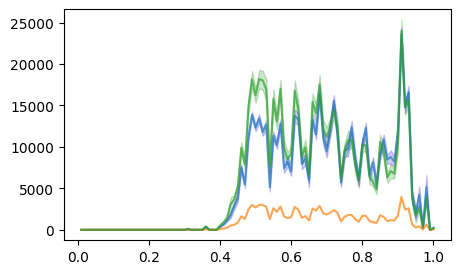

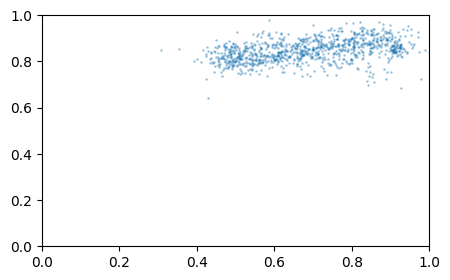

2024
Волгоградская область 1763312.0


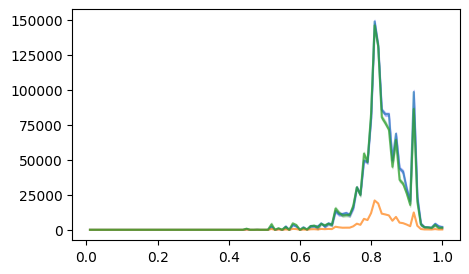

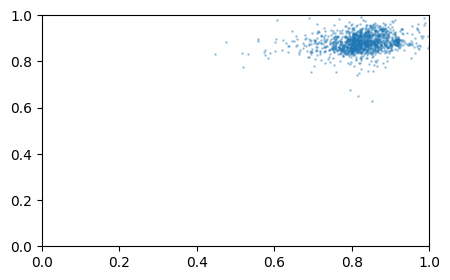

2024
Вологодская область 775300.0


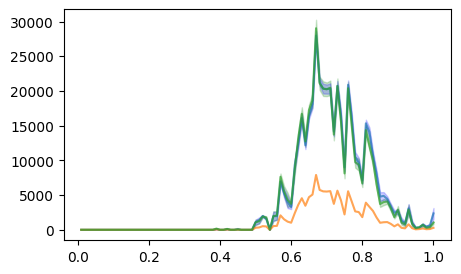

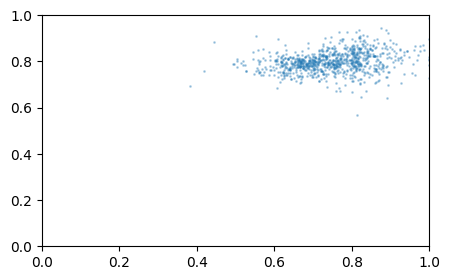

2024
Воронежская область 1630522.0


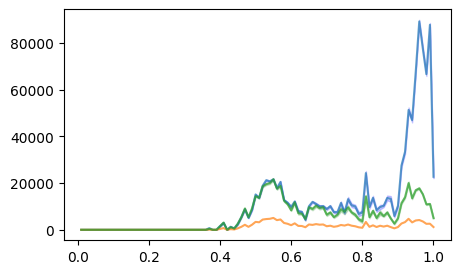

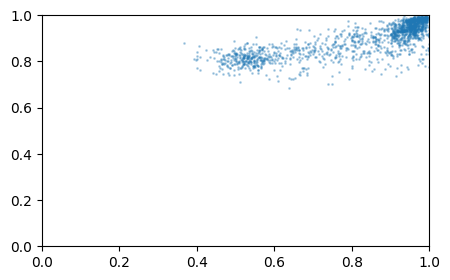

2024
Еврейская автономная область 115928.0


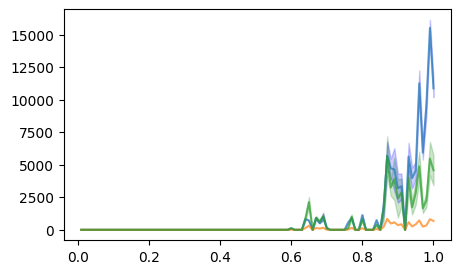

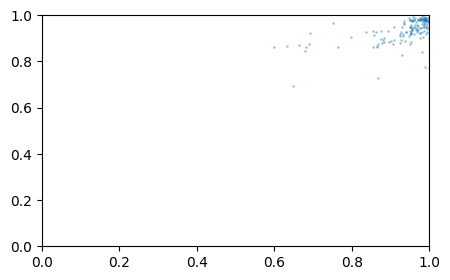

2024
Забайкальский край 739946.0


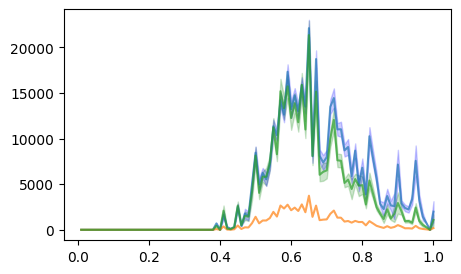

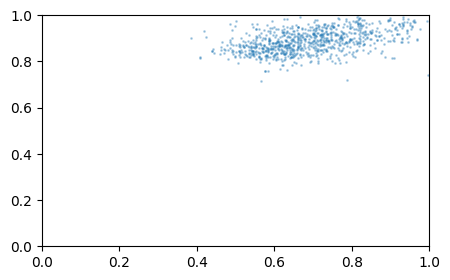

2024
Ивановская область 754505.0


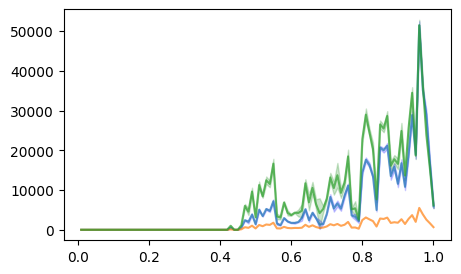

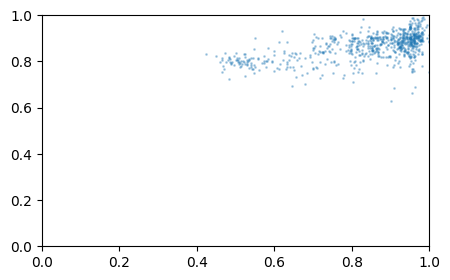

2024
Иркутская область 1785111.0


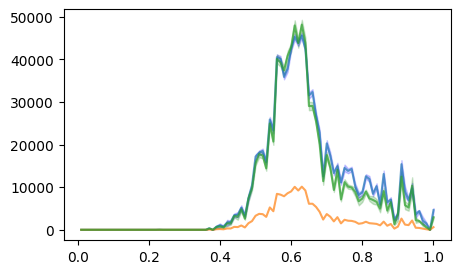

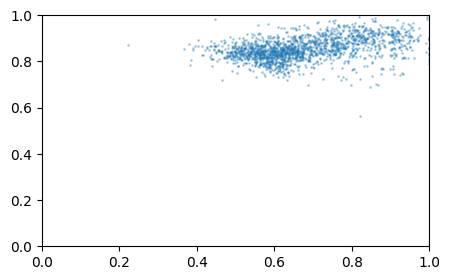

2024
Кабардино-Балкарская Республика 540501.0


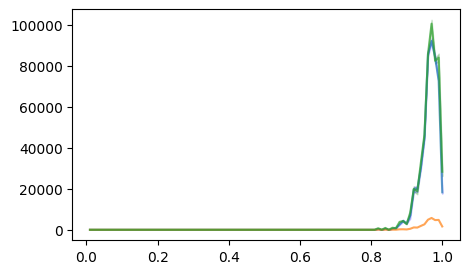

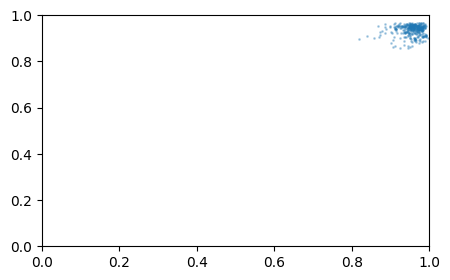

2024
Калининградская область 774197.0


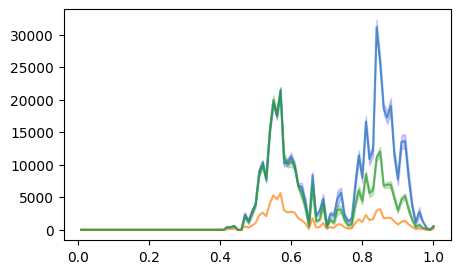

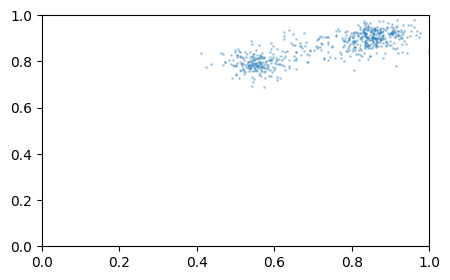

2024
Калужская область 695258.0


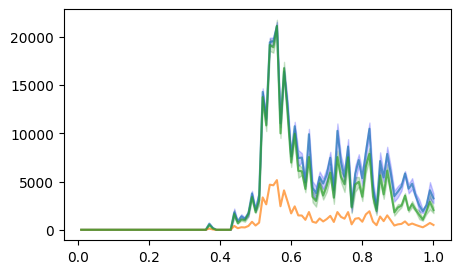

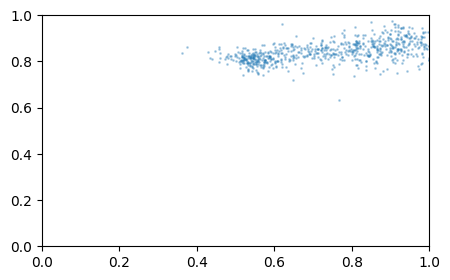

2024
Камчатский край 183878.0


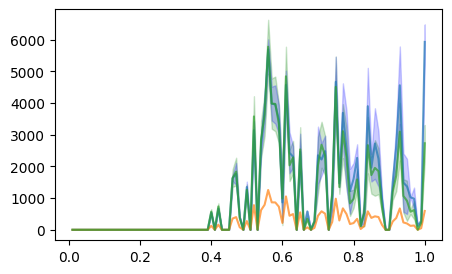

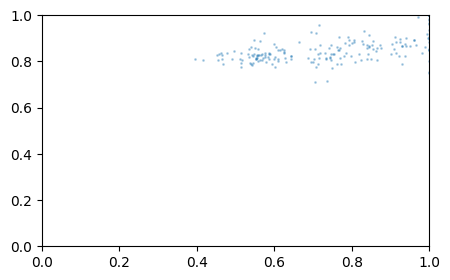

2024
Карачаево-Черкесская Республика 295266.0


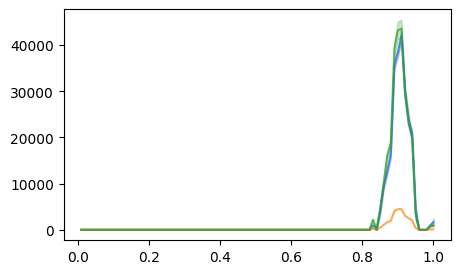

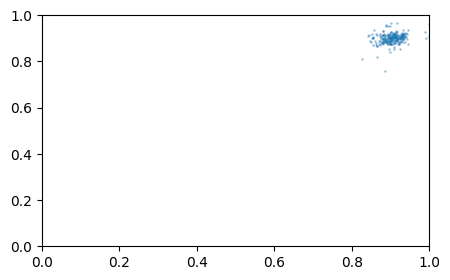

2024
Кемеровская область - Кузбасс 1873195.0


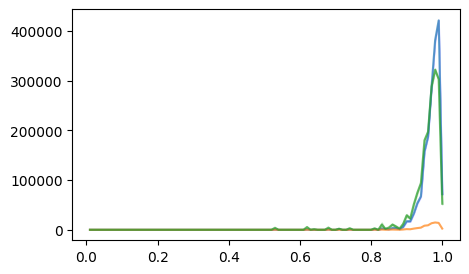

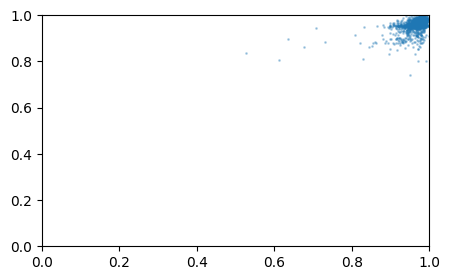

2024
Кировская область 979689.0


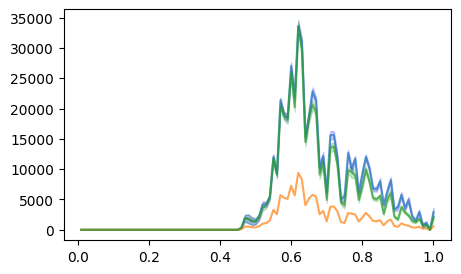

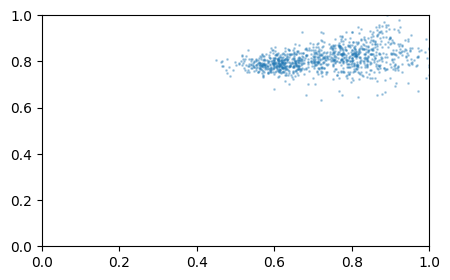

2024
Костромская область 489114.0


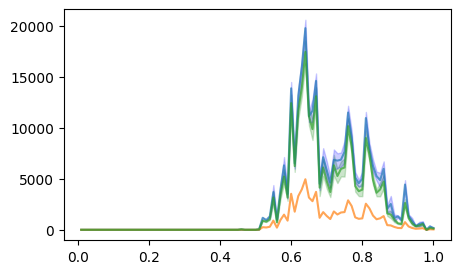

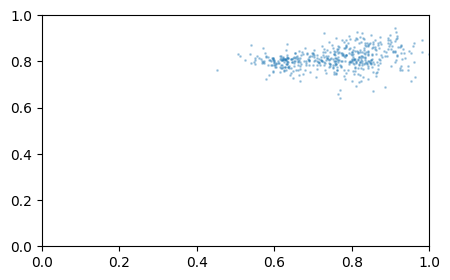

2024
Краснодарский край 4421167.0


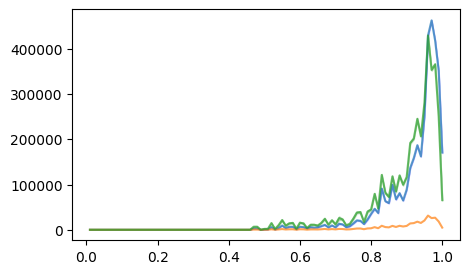

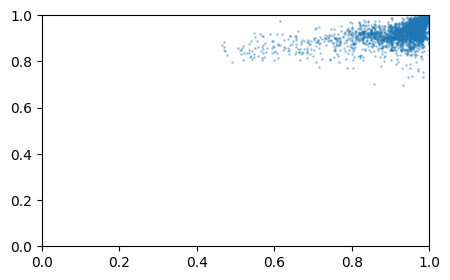

2024
Красноярский край 1863253.0


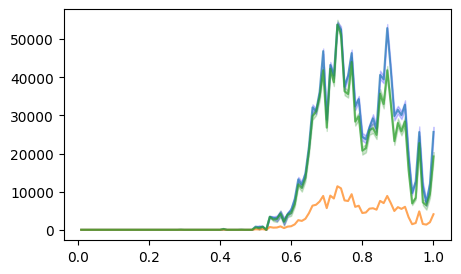

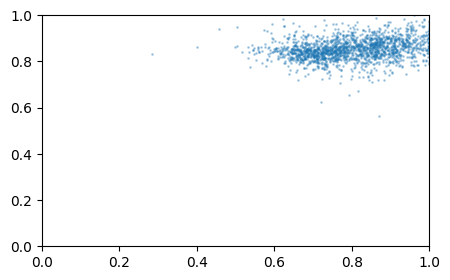

2024
Курганская область 631885.0


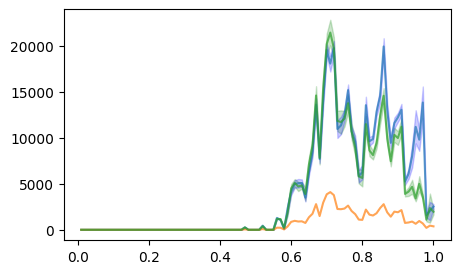

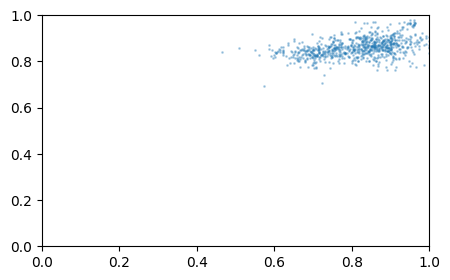

2024
Курская область 779028.0


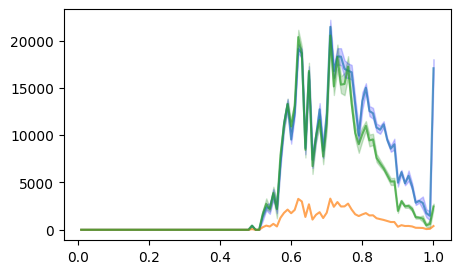

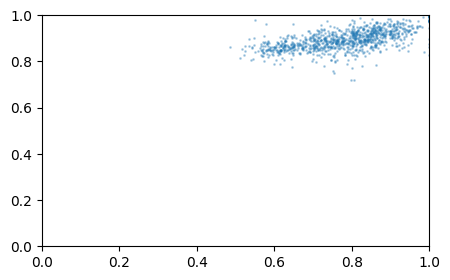

2024
Ленинградская область 1435710.0


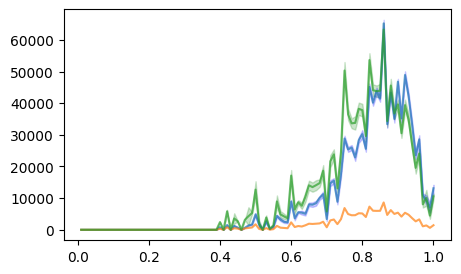

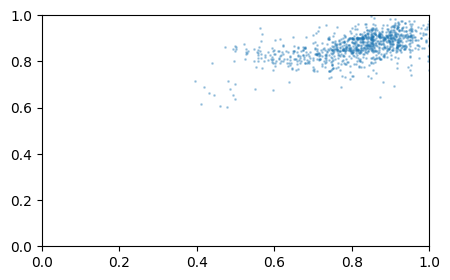

2024
Липецкая область 784396.0


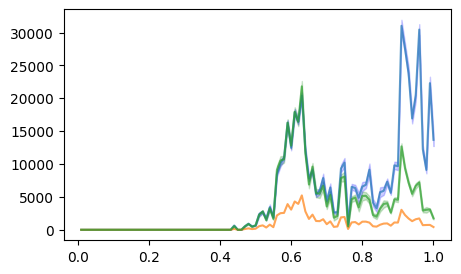

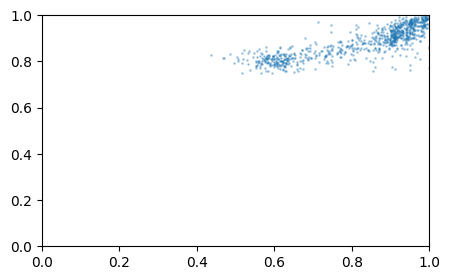

2024
Магаданская область 100905.0


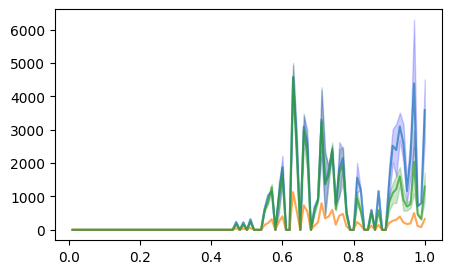

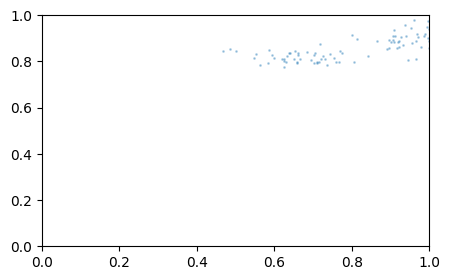

2024
Московская область 5374543.0


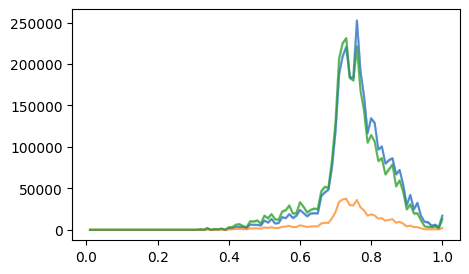

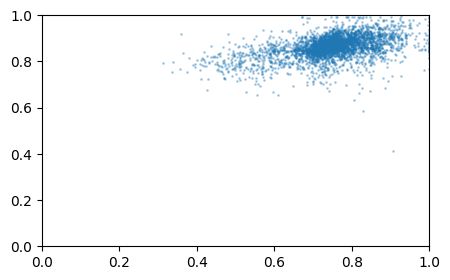

2024
Мурманская область 457529.0


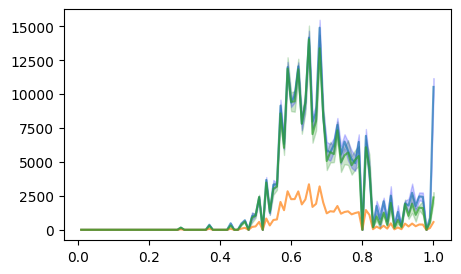

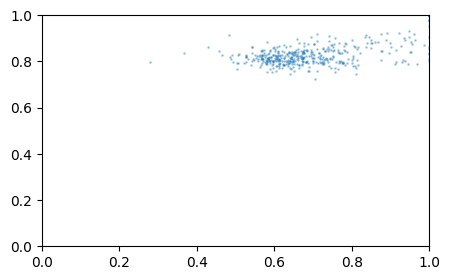

2024
Ненецкий автономный округ 34510.0


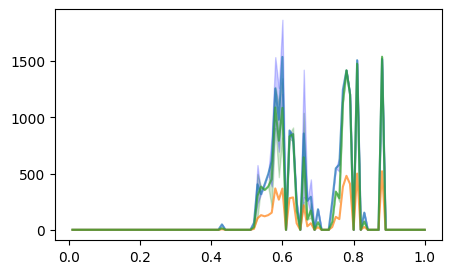

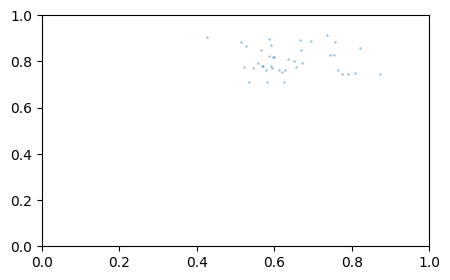

2024
Нижегородская область 2194879.0


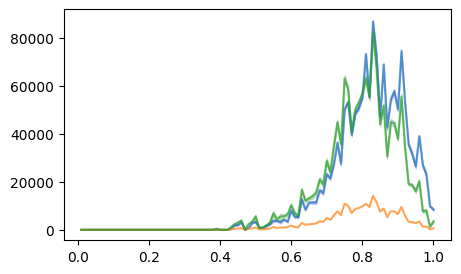

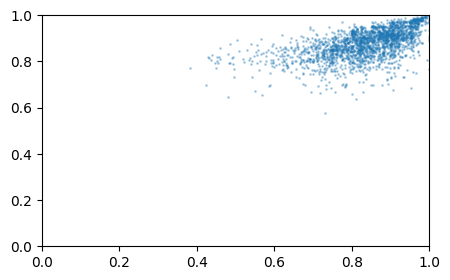

2024
Новгородская область 437257.0


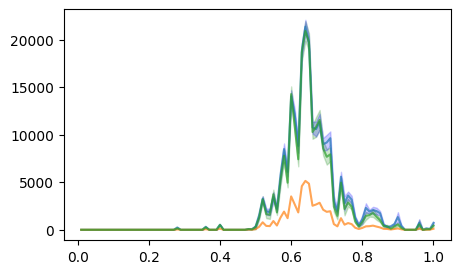

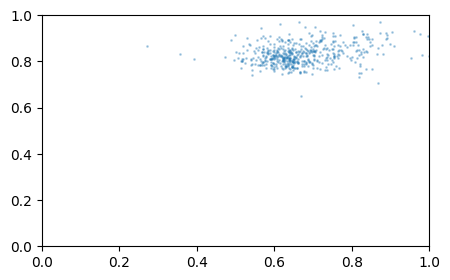

2024
Новосибирская область 1951886.0


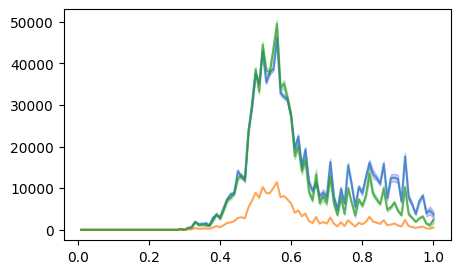

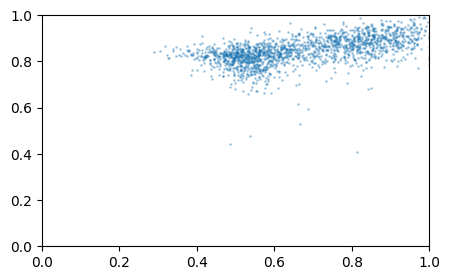

2024
Омская область 1420613.0


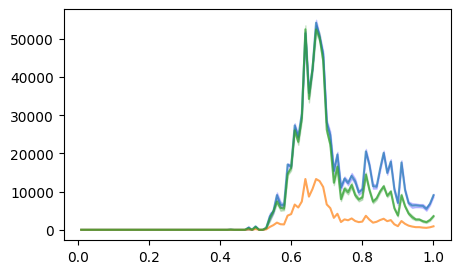

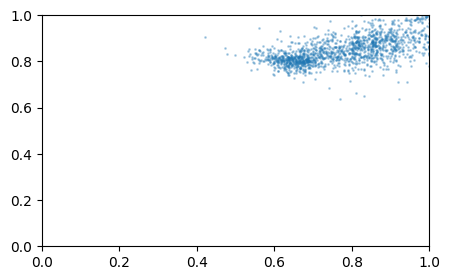

2024
Оренбургская область 1476132.0


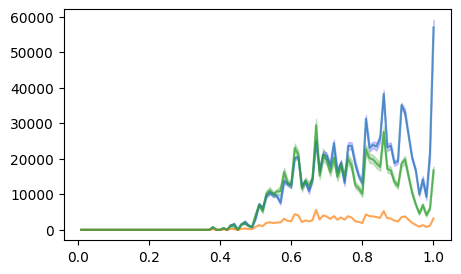

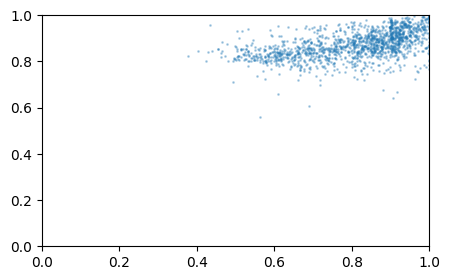

2024
Орловская область 586517.0


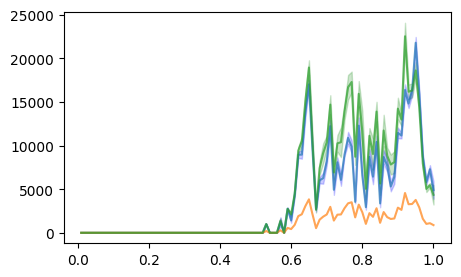

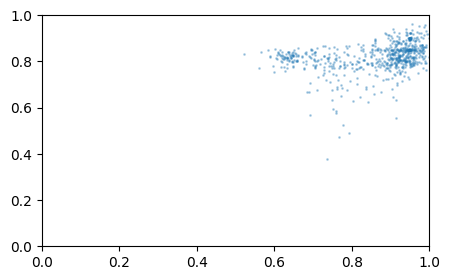

2024
Пензенская область 999096.0


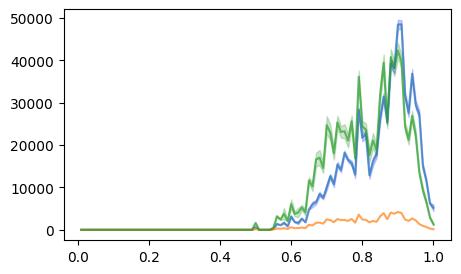

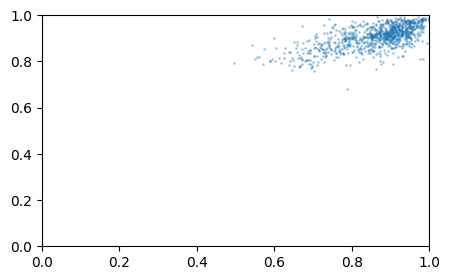

2024
Пермский край 1771767.0


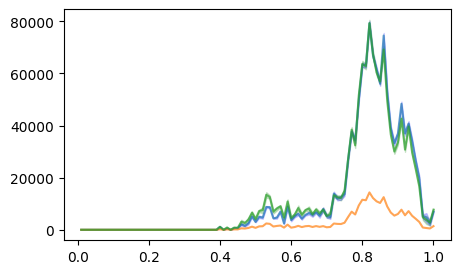

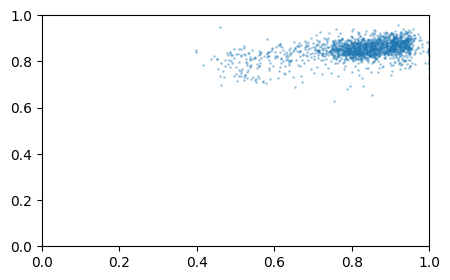

2024
Приморский край 1421139.0


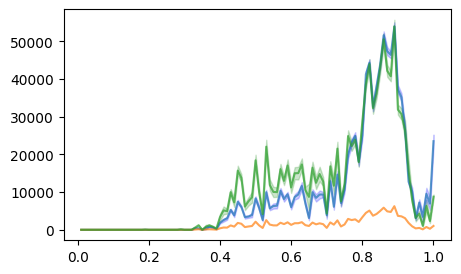

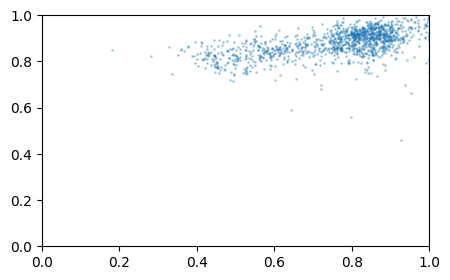

2024
Псковская область 421574.0


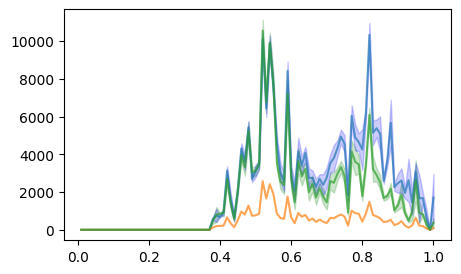

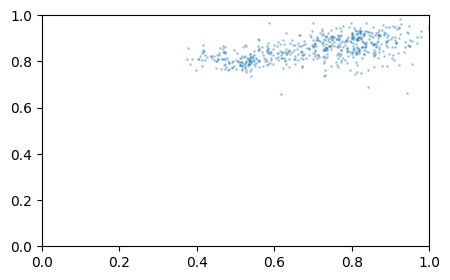

2024
Республика Адыгея (Адыгея) 345149.0


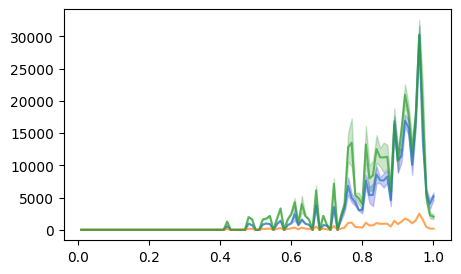

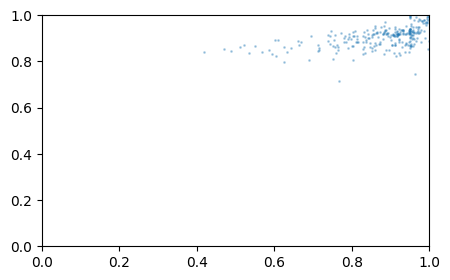

2024
Республика Алтай 150632.0


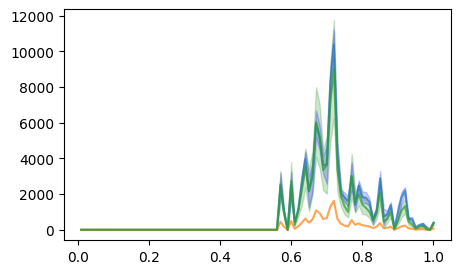

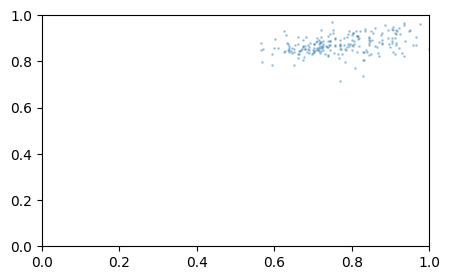

2024
Республика Башкортостан 2936296.0


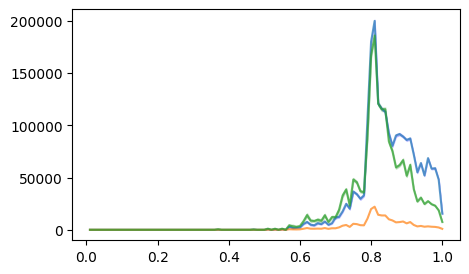

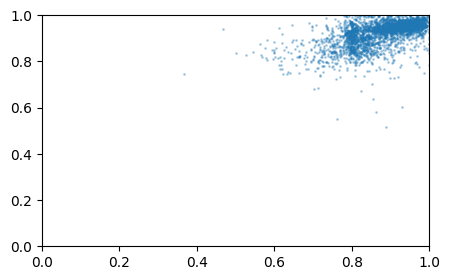

2024
Республика Бурятия 664629.0


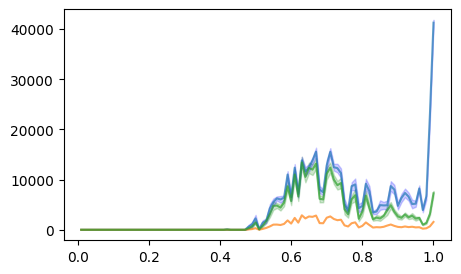

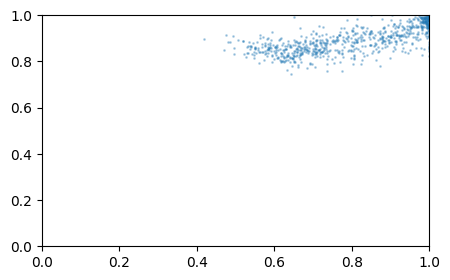

2024
Республика Дагестан 1421931.0


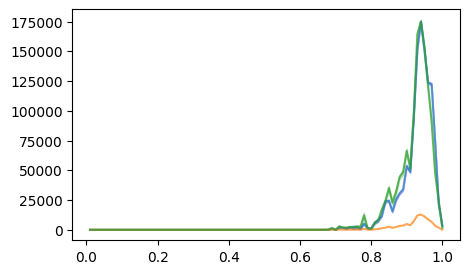

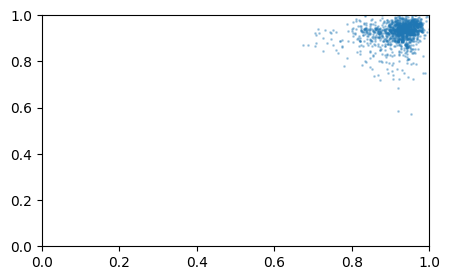

2024
Республика Ингушетия 246401.0


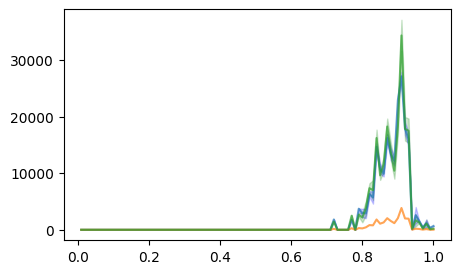

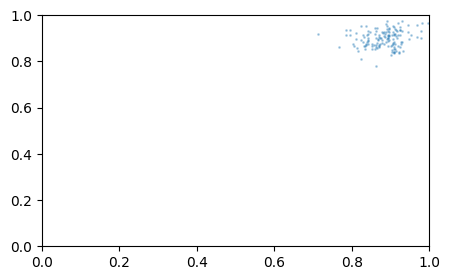

2024
Республика Калмыкия 196575.0


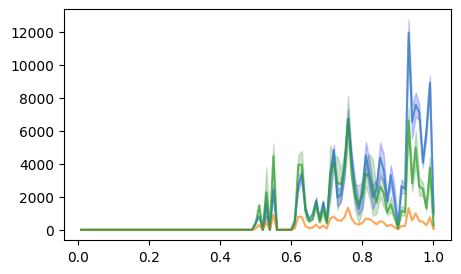

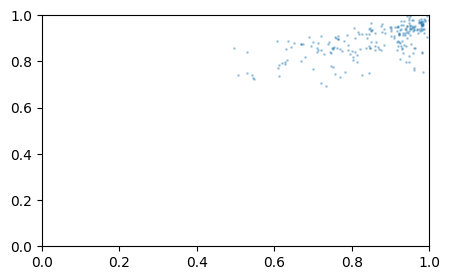

2024
Республика Карелия 440403.0


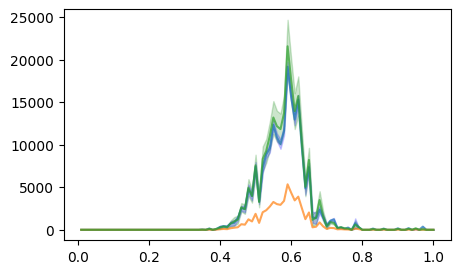

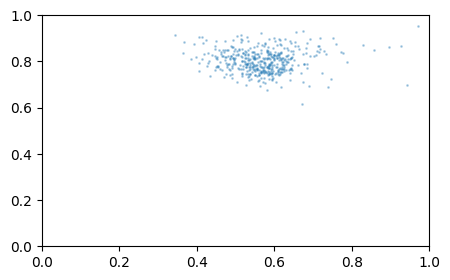

2024
Республика Коми 607766.0


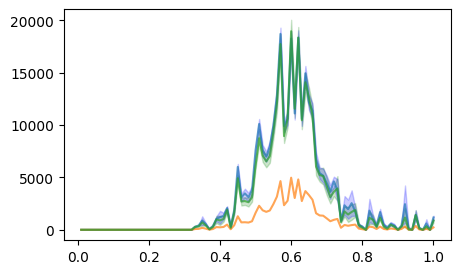

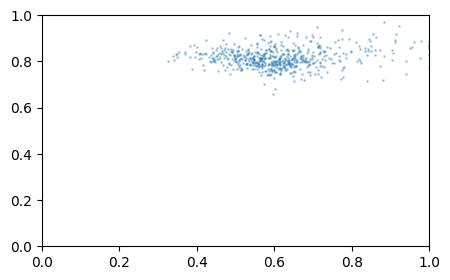

2024
Республика Крым 1373848.0


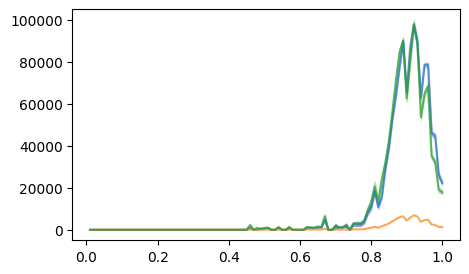

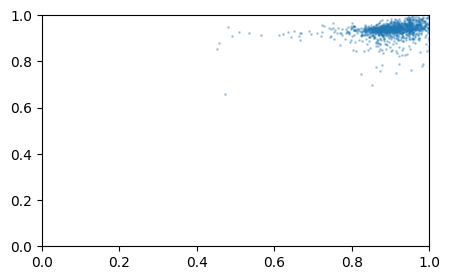

2024
Республика Марий Эл 518490.0


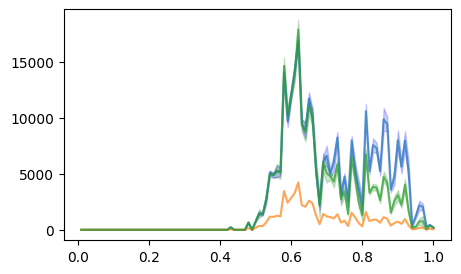

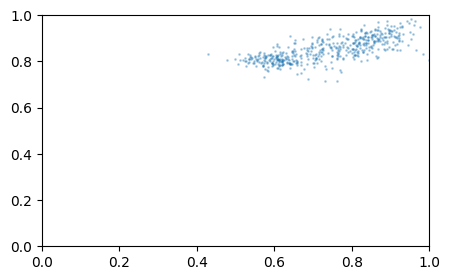

2024
Республика Мордовия 564233.0


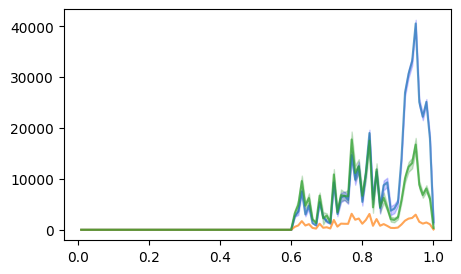

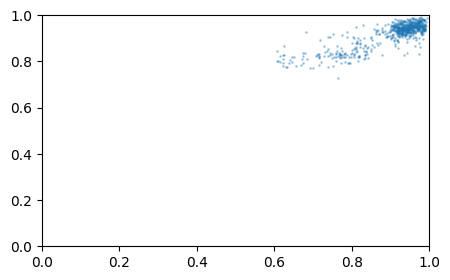

2024
Республика Саха (Якутия) 628534.0


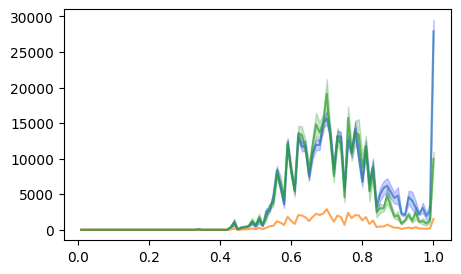

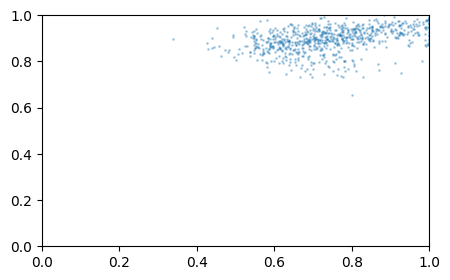

2024
Республика Северная Осетия - Алания 505122.0


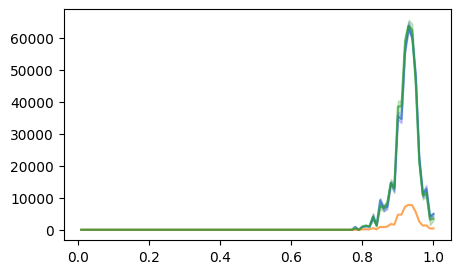

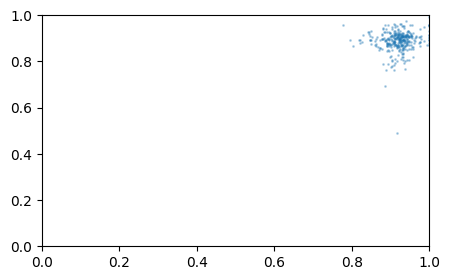

2024
Республика Татарстан (Татарстан) 2923916.0


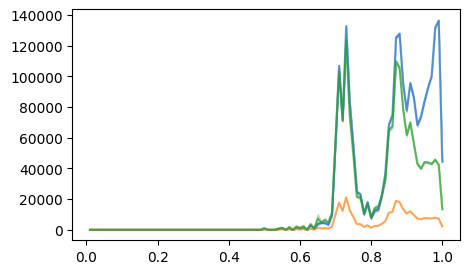

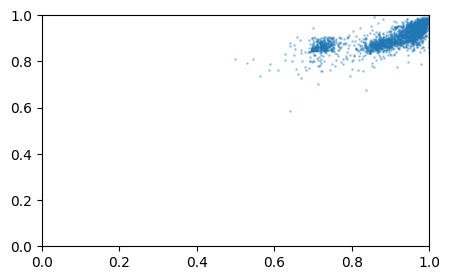

2024
Республика Тыва 198420.0


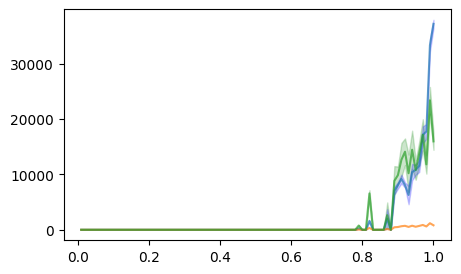

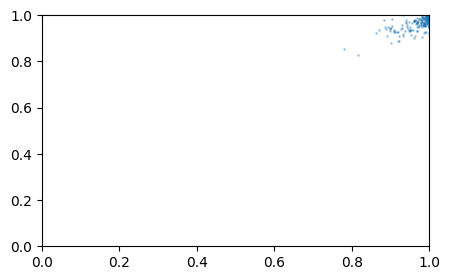

2024
Республика Хакасия 384155.0


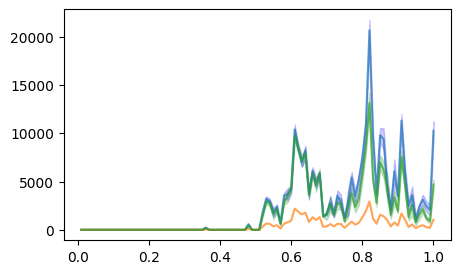

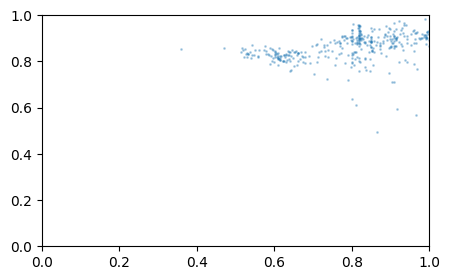

2024
Ростовская область 2766407.0


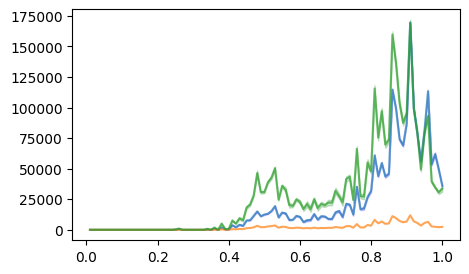

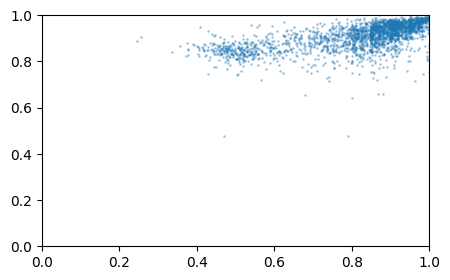

2024
Рязанская область 872611.0


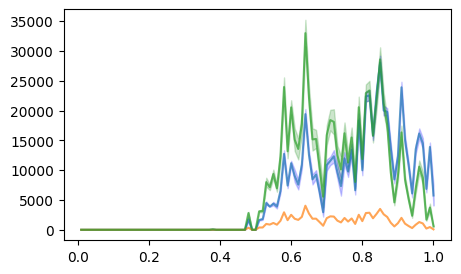

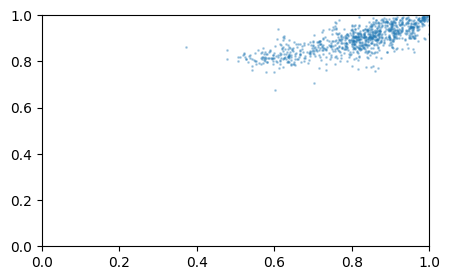

2024
Самарская область 2387389.0


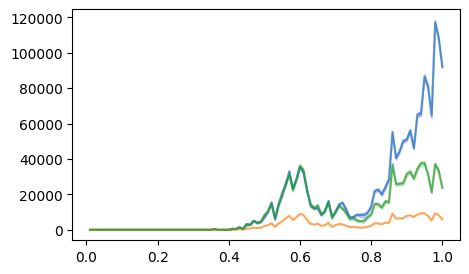

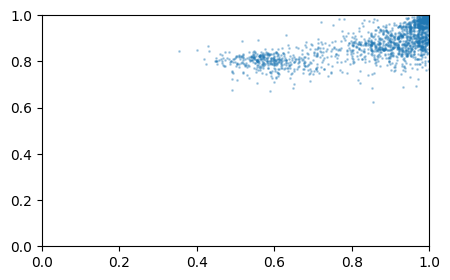

2024
Саратовская область 1788717.0


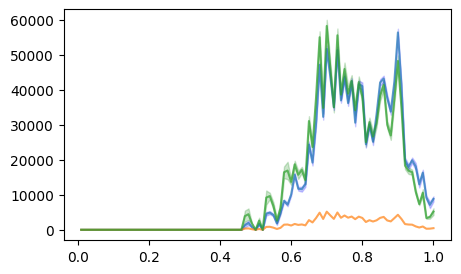

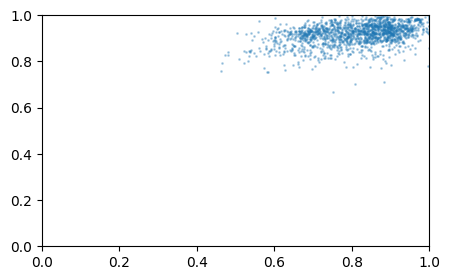

2024
Сахалинская область 365492.0


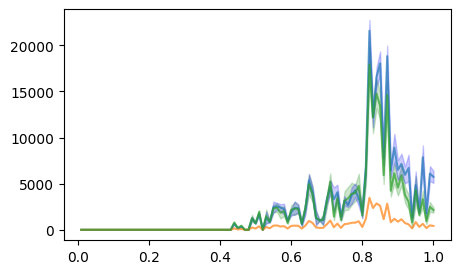

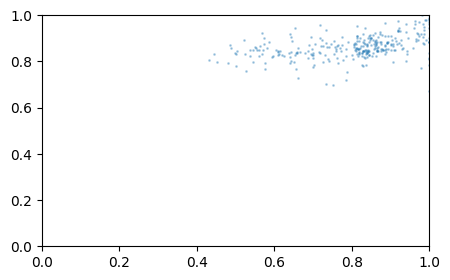

2024
Свердловская область 2997671.0


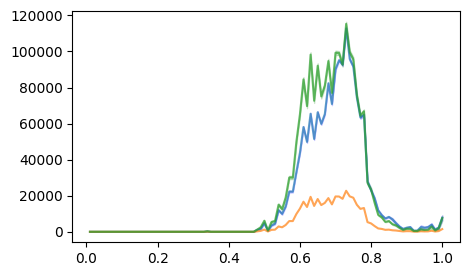

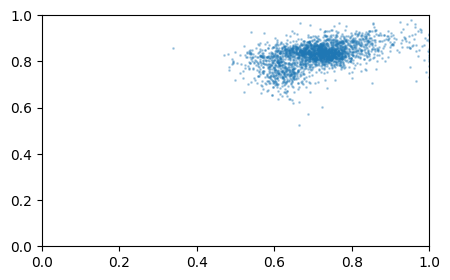

2024
Смоленская область 708218.0


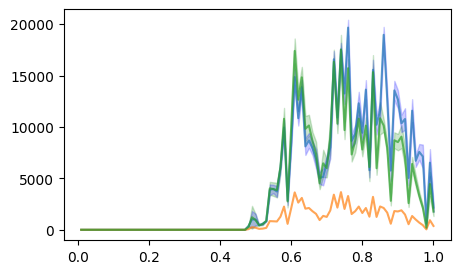

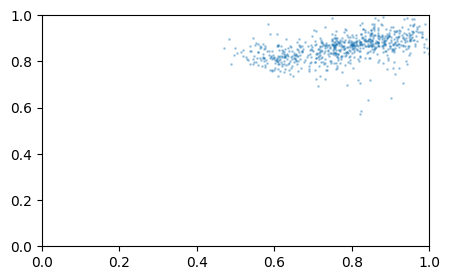

2024
Ставропольский край 1888411.0


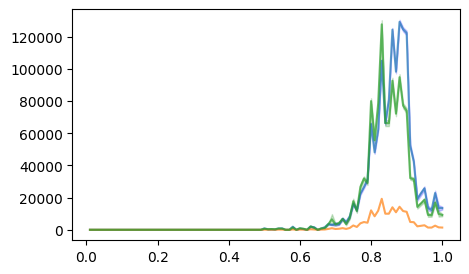

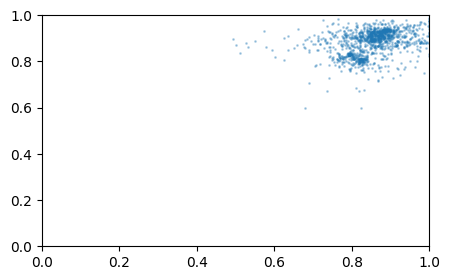

2024
Тамбовская область 785031.0


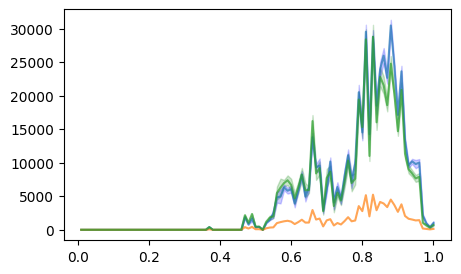

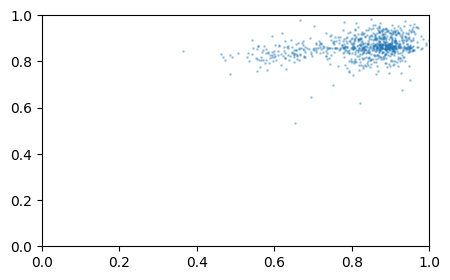

2024
Тверская область 998199.0


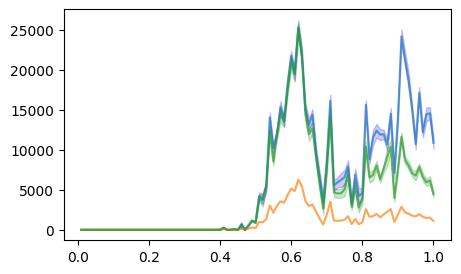

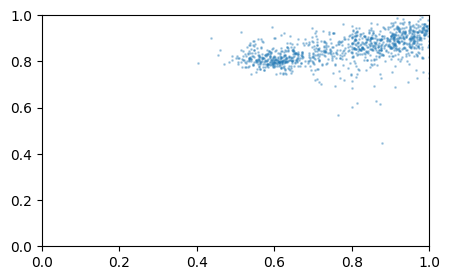

2024
Томская область 667231.0


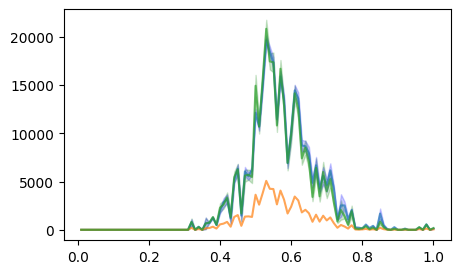

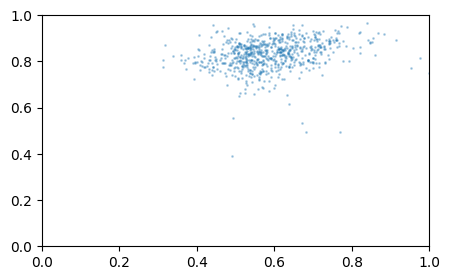

2024
Тульская область 1130446.0


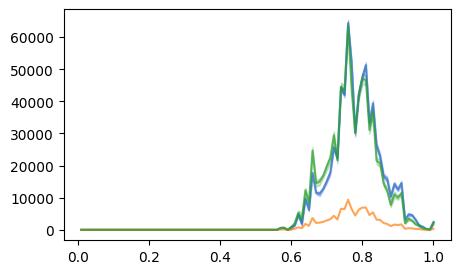

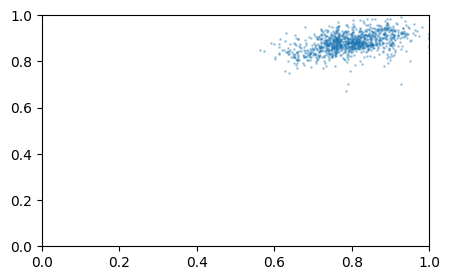

2024
Тюменская область 1180175.0


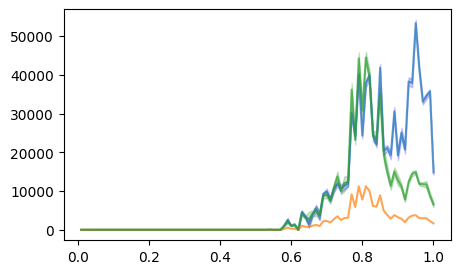

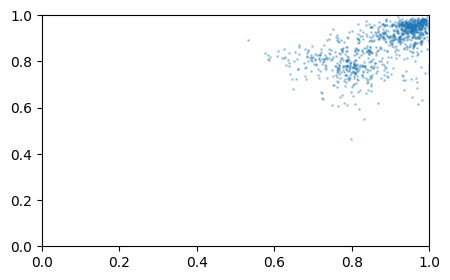

2024
Удмуртская Республика 1152752.0


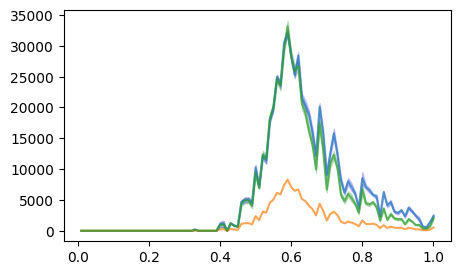

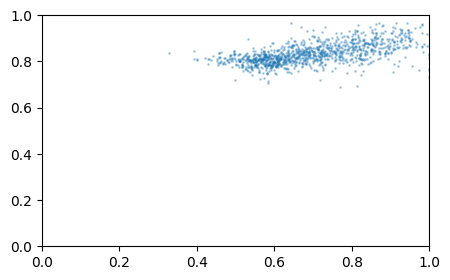

2024
Ульяновская область 929922.0


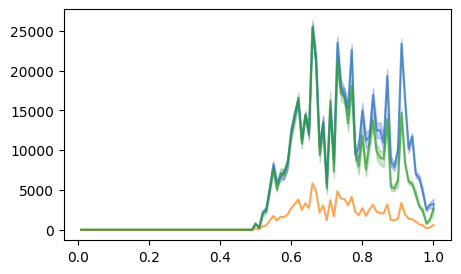

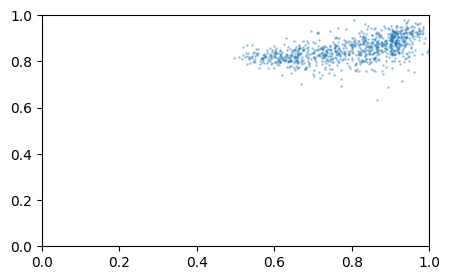

2024
Хабаровский край 946285.0


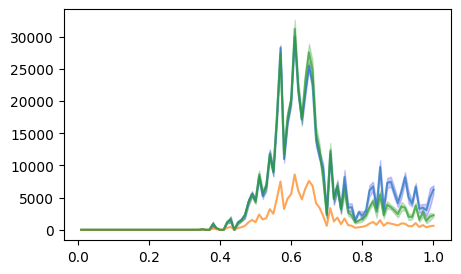

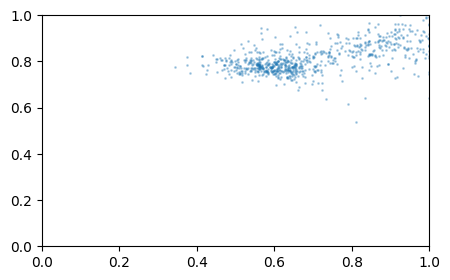

2024
Ханты-Мансийский автономный округ - Югра 1140112.0


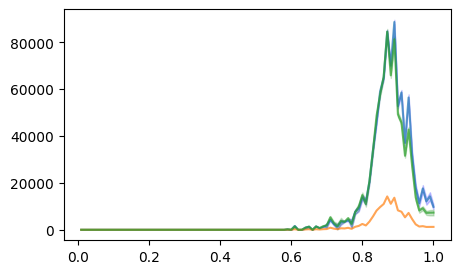

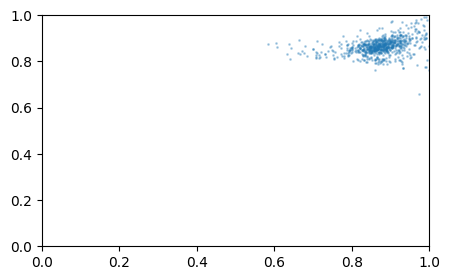

2024
Челябинская область 2325552.0


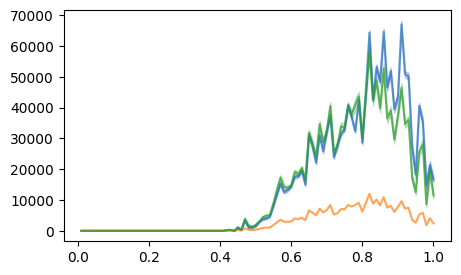

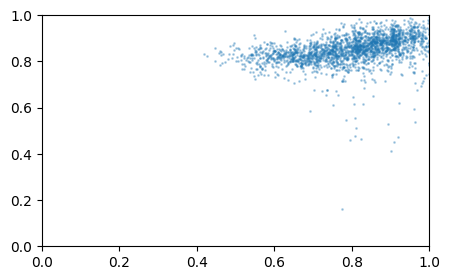

2024
Чеченская Республика 816123.0


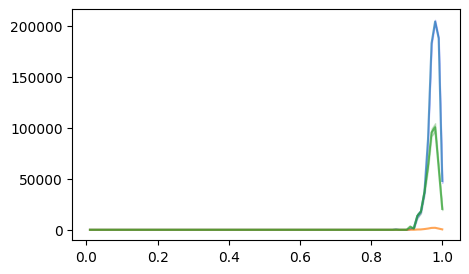

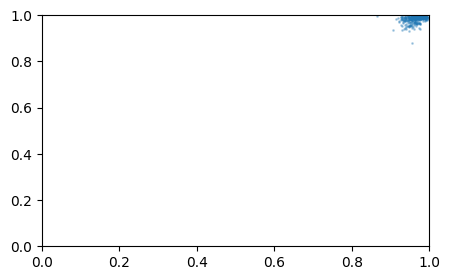

2024
Чувашская Республика - Чувашия 663047.0


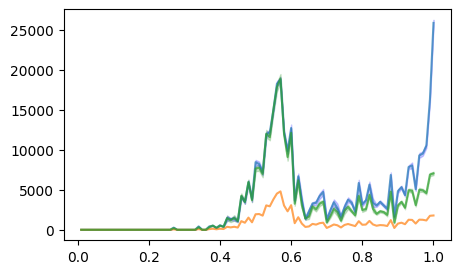

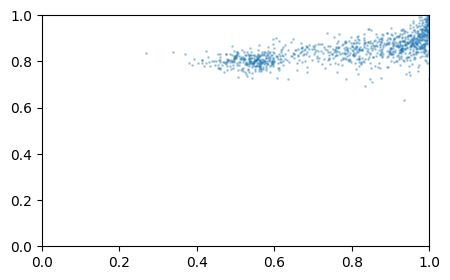

2024
Чукотский автономный округ 32756.0


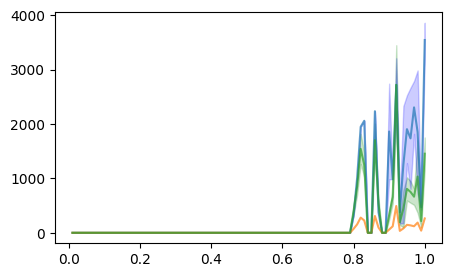

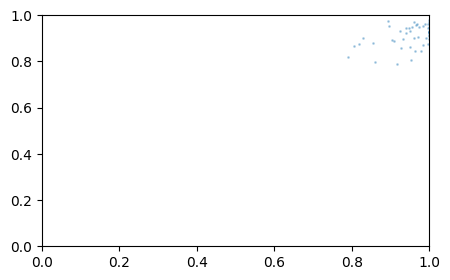

2024
Ямало-Ненецкий автономный округ 375466.0


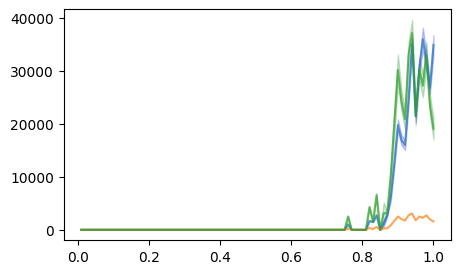

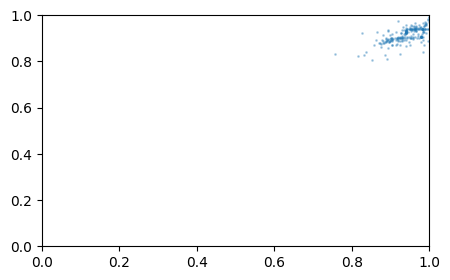

2024
Ярославская область 755224.0


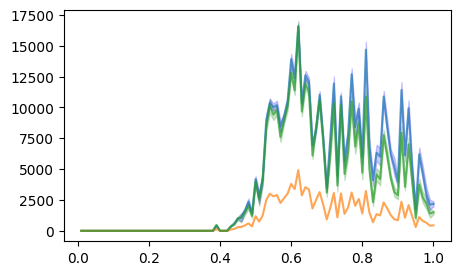

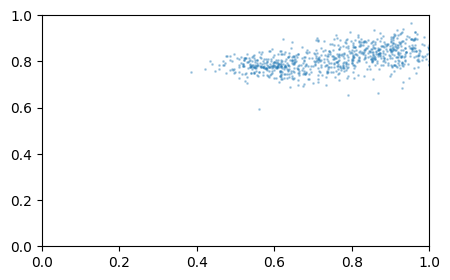

2024
город Москва 4433204.0


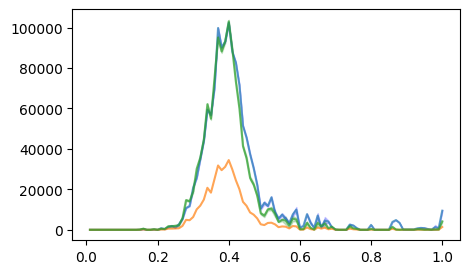

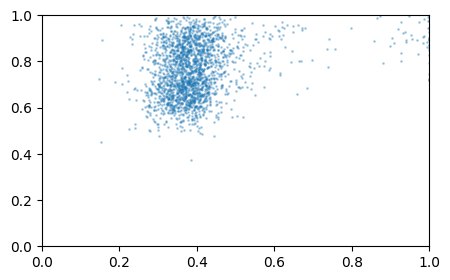

2024
город Санкт-Петербург 3836526.0


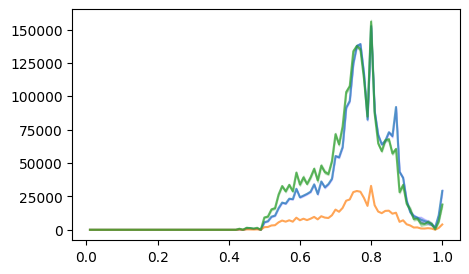

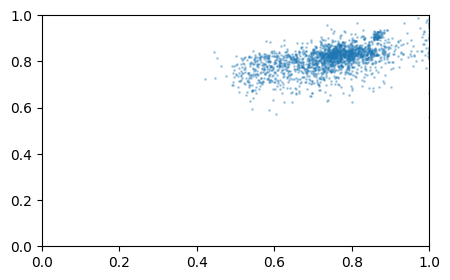

2024
город Севастополь 313447.0


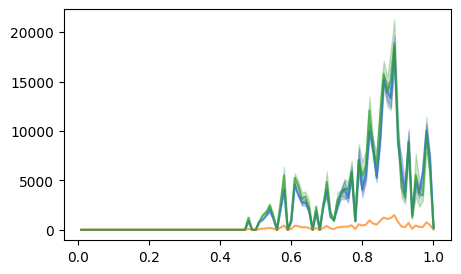

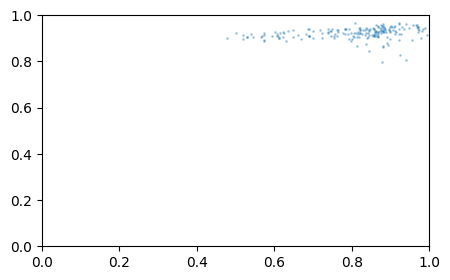

In [65]:
for r in regions:
    plot_region_year(r, 2024)

## Federal

2000
105370543


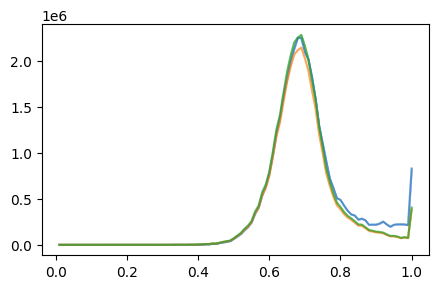

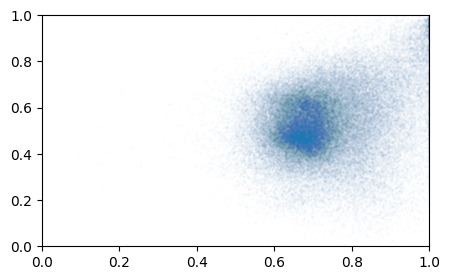

2003
108604224


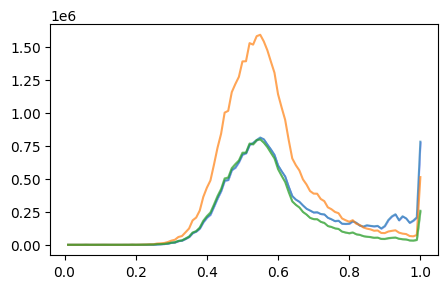

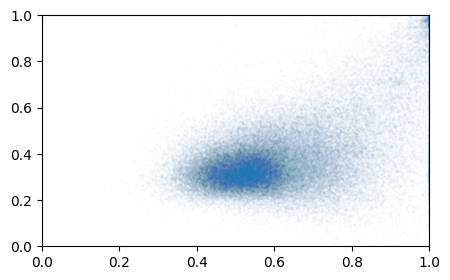

2004
107745565


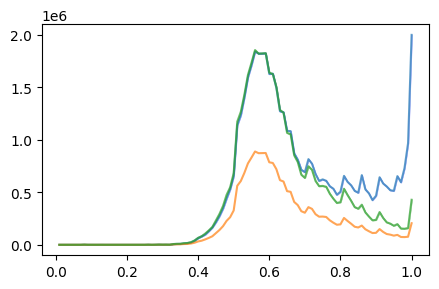

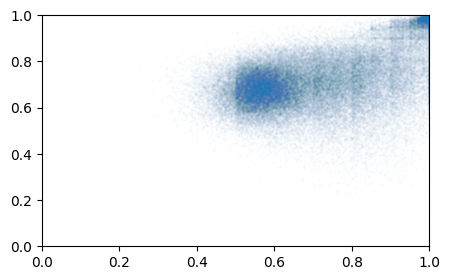

2007
108835246


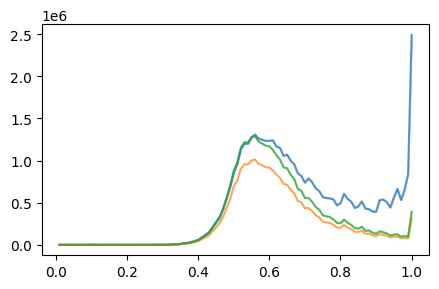

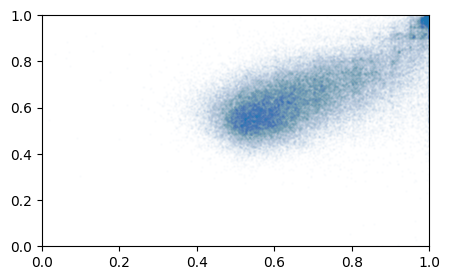

2008
106901369


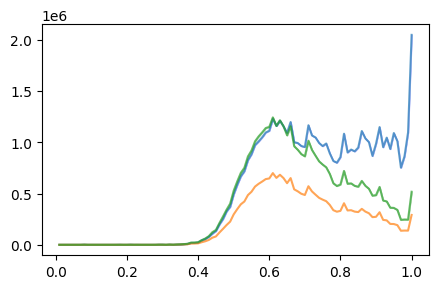

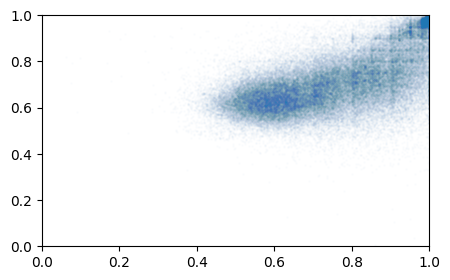

2011
108957789


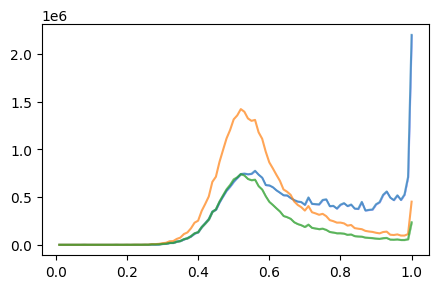

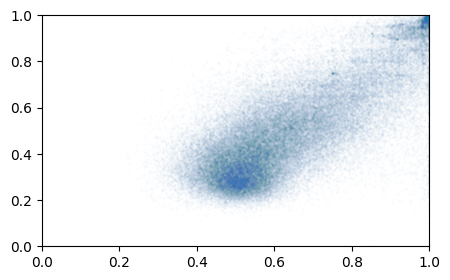

2012
109585306


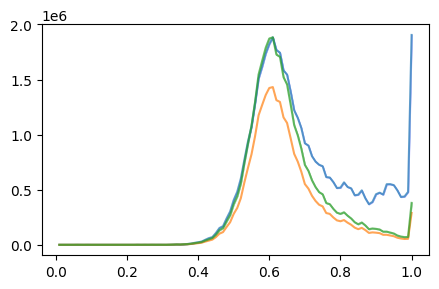

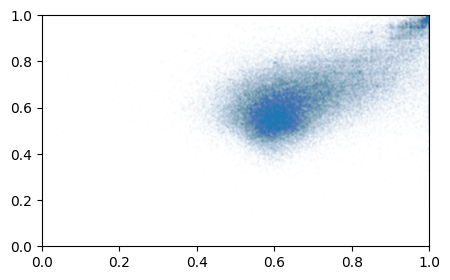

2016
109804646


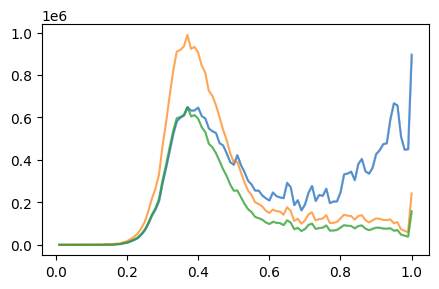

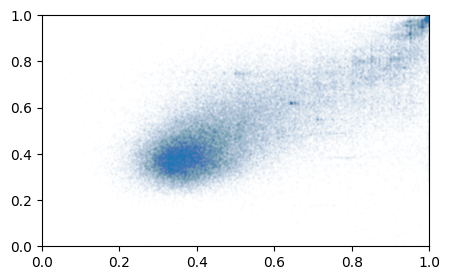

2018
108743606


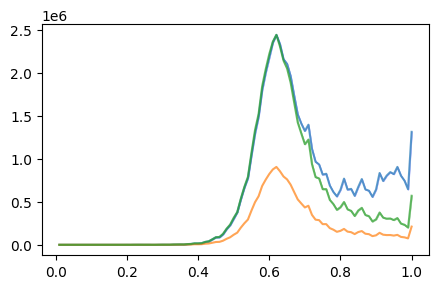

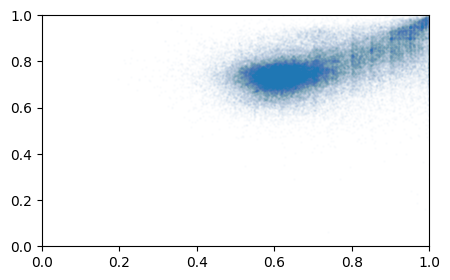

2020
107738875


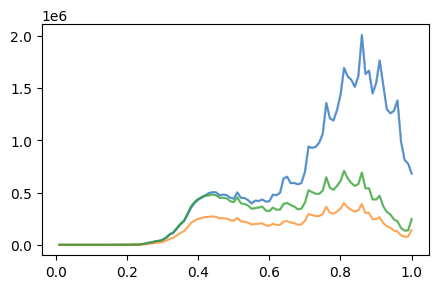

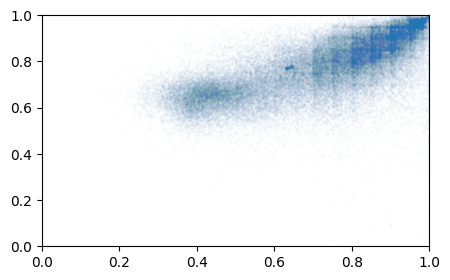

2021
108946161


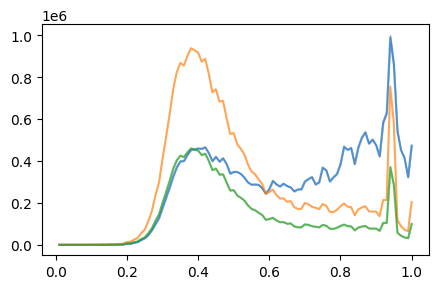

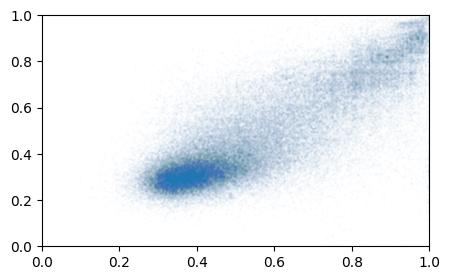

2024
99007165.0


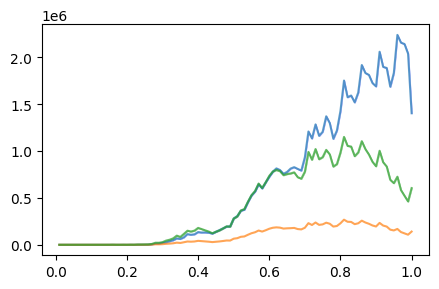

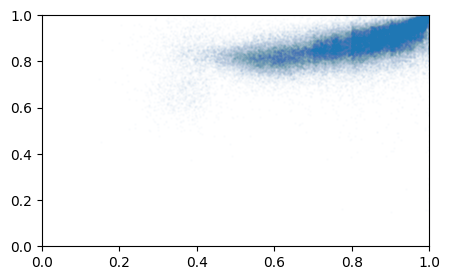

In [19]:
n_other_full_years = []
indmax_full_years = []

n_votes = []
n_percents = []

for i,y in enumerate(years):

    print(y)

    i = years.index(y)

    d = data_years_filtered[i]
    
    data_r = d
    # if y == 2024:
    #     data_r = d[d['region']!='город Москва']
    print(sum(data_r['total_citizens']))

    n_leader, n_other, std_leader, std_other = get_shpilkin_plot(data_r)

    try:
        gauss_y, indmax = fit_bimodal(percents[1:], smooth(n_other), np.argmax(smooth(n_other))/100, max(smooth(n_other)))
    except:
        gauss_y = []

    plt.figure(figsize = [5,3])
    plt.plot(percents[1:], n_leader, alpha = 0.7)
    plt.plot(percents[1:], n_other, alpha = 0.7)
    
    if len(gauss_y)>0:
        # plt.plot(percents[1:], gauss_y, alpha = 0.7, c = 'red')
        pass
    else:
        indmax = np.argmax(n_other[:-3])

    if y == 2020:
        indmax = 40
    elif y == 2024:
        indmax = 60#40
    

    n_other_full_years.append(n_other)
    indmax_full_years.append(indmax)

    true_leader, coeff = get_true_leader_votes(n_leader, n_other, indmax)

    df_res = pd.DataFrame({'n_leader': n_leader, 'n_other': n_other, 'n_corrected': true_leader})
    df_res.to_csv('./spilkin_plots_federal/'+str(y)+'.csv')

    sumsqrt = []
    for j in range(100):
        s = 0
        if n_other[j]>0:
            s += (std_other[j]/n_other[j])**2
        if n_leader[indmax]>0:
            s += (std_leader[indmax]/n_leader[indmax])**2
        sumsqrt.append(s)
    
    deltas = true_leader*np.sqrt(np.array(sumsqrt))

    n_votes.append(sum(n_leader) - sum(true_leader))
    # n_percents.append(sum(n_leader)/(sum(n_leader)+sum(n_other)) - sum(true_leader)/(sum(true_leader)+sum(n_other)))
    n_percents.append((sum(n_leader) - sum(true_leader))/sum(n_leader))

    plt.plot(percents[1:], true_leader, alpha = 0.7)
    plt.fill_between(percents[1:], true_leader-2*deltas, true_leader+2*deltas, color = 'green', alpha = 0.2)
    plt.fill_between(percents[1:], n_leader-2*std_leader, n_leader+2*std_leader, color = 'blue', alpha = 0.2)
    plt.show()
    
    plt.figure(figsize = [5,3])
    plt.scatter(data_r['turnout'], data_r['result_leader'], s = 1, alpha = 0.01)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

In [128]:
df = pd.DataFrame({'leader_votes': n_leader,
                  'other_votes': n_other,
                  'leader_corrected': true_leader})

In [129]:
df.to_csv('шпилькин_общероссийский.csv', index = False)

In [20]:
for n in n_votes:
    print(n)

1883705.8696641177
3736104.5043885186
7889226.150477871
12945302.389693119
12966109.118339963
14932292.408070825
11183822.183302537
12653698.812198855
10138780.23928681
28666717.522663247
14144280.880691845
22518424.067378804


In [21]:
for n in n_percents:
    print(n*100)

4.920470713022538
16.48224074731159
15.985409320978913
29.081638124665492
24.783529879967496
46.32306231285611
24.61354845375872
44.54147905940567
18.02261840402675
50.388243993547256
50.59514425998092
34.81172697987861


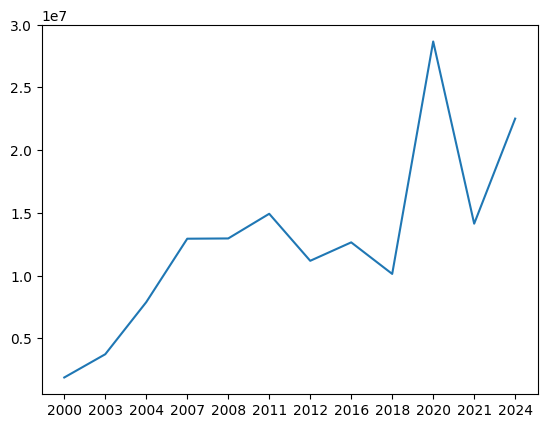

In [22]:
plt.figure()
plt.plot(n_votes)
t = plt.xticks(range(len(years)), years)

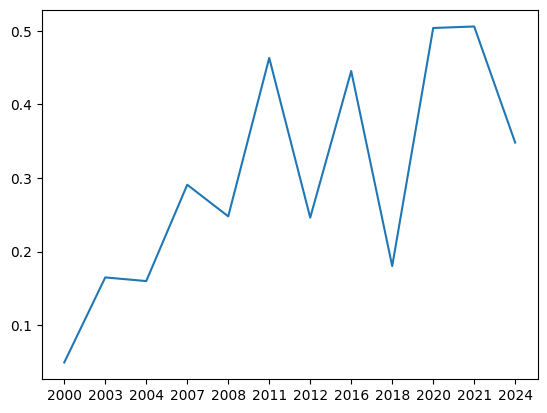

In [23]:
plt.figure()
plt.plot(n_percents)
t = plt.xticks(range(len(years)), years)

# Integer anomalies

## Illustration

In [40]:
bins = np.linspace(0,1,1001)
# bins = np.linspace(0,1,501)

In [41]:
def smooth(y, box_pts = 5):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[-2:] = y[-2:]
    return y_smooth

In [42]:
def get_kobak_plot(data_r, stations = False, column = 'turnout'):

    n_leader = []
    n_leader_std = []
    n_other = []
    for p in range(len(bins)-1):
        data_p = data_r[data_r[column]>bins[p]][data_r[column]<=bins[p+1]]
        if stations:
            n_leader.append(len(data_p))
        else:
            n_leader.append(np.sum(data_p['leader']))
        n_other.append(sum(data_p['total_voters']) - sum(data_p['leader']))

    n_smooth = np.array(smooth(n_leader, box_pts = 7))
    n_leader = np.array(n_leader)
    std = np.std(n_leader - n_smooth)

    return np.array(n_leader), np.array(n_other), np.array(n_smooth), std

In [43]:
def exclude_integer_values(bins, n_leader):
    
    n_new = []

    for i in range(len(bins)-1):
        if len(bins)==1001:
            if (np.mod(i,10) not in [9,0,1,2]) or (i<10):
                n_new.append(n_leader[i])
            else:
                if i<=998:
                    if np.mod(i,10) == 9:
                        n_new.append((np.average(n_leader[int(i/10)*10+3:int(i/10)*10+8]) + np.average(n_leader[int(i/10)*10+13:int(i/10)*10+18]))/2)
                    else:
                        n_new.append((np.average(n_leader[int(i/10)*10-7:int(i/10)*10-2]) + np.average(n_leader[int(i/10)*10+3:int(i/10)*10+8]))/2)
                else:
                    n_new.append(n_leader[int(i/10)*10-2])
        else:
            if (np.mod(i,5) not in [4,0,1]) or (i<10):
                n_new.append(n_leader[i])
            else:
                if i<=499:
                    if np.mod(i,5)==4:
                        n_new.append((np.average(n_leader[int(i/5)*5+2:int(i/5)*5+4]) + np.average(n_leader[int(i/5)*5+7:int(i/5)*5+9]))/2)
                    else:
                        n_new.append((np.average(n_leader[int(i/5)*5-3:int(i/5)*5-1]) + np.average(n_leader[int(i/5)*5+2:int(i/5)*5+4]))/2)
                else:
                    n_new.append(n_leader[int(i/5)*5-1])
        
    return n_new

In [44]:
def count_exceed_integer_votes(data, n_std = 1, only_significant = False, stations = False, xlim = [0,1], column = 'turnout'):
    
    n_leader, n_other, n_smooth, std = get_kobak_plot(data, stations, column)
    
    n_new = exclude_integer_values(bins, n_leader)

    n_smooth = np.array(smooth(n_new, box_pts = 7))
    n_peaks = np.array(n_leader)-np.array(n_new)

    df = pd.DataFrame({'bins': bins[1:]*100,
                      'leader_votes': n_leader,
                      'votes_without_peaks': n_smooth,
                      'leader_votes_no_peaks': [n_new[i] if n_new[i]<n_leader[i] else n_leader[i] for i in range(len(n_new))],
                      'leader_votes_peaks': [n_peaks[i] if n_peaks[i]>0 else 0 for i in range(len(n_new))]})
    # df.to_csv('целочисленные_'+column+'.csv', index = False)
    
    plt.figure(figsize = [10,3])
    if n_std:
        plt.fill_between(bins[:-2], n_smooth[:-1]-n_std*std, n_smooth[:-1]+n_std*std, alpha = 0.3, color = 'yellow')
    plt.plot(bins[:-2],n_leader[:-1], lw = 0.7, alpha = 0.8)
    plt.plot(bins[:-2],n_new[:-1], lw = 0.7, alpha = 0.8)
    plt.plot(bins[:-2], n_smooth[:-1], lw = 0.7, alpha = 0.8)
    if column == 'turnout':
        plt.xlabel('Turnout, %')
    else:
        plt.xlabel("Leader's result, %")
    if not stations:
        plt.ylabel('Votes for leader')
    else:
        plt.ylabel('Number of stations')
    plt.xlim(xlim)
    plt.tight_layout()
    plt.show()

    if only_significant:
        n_total = 0
        for i in range(len(n_leader-1)):
            if n_leader[i]-n_new[i] > n_std*std:
                n_total += n_leader[i]-n_new[i]
    else:
        # n_total = sum(n_leader[:-1] - n_new[:-1])
        n_total = np.nansum(n_leader[:-1] - n_smooth[:-1])

    if not stations:
        n_percent = n_total/(sum(n_leader[:-1])+sum(n_other[:-1]))
    else:
        n_percent = n_total/len(data)

    return n_total, n_percent, std

In [45]:
ind = years.index(2008) #an example on 2008 year's data

In [46]:
data = data_years_filtered[ind]

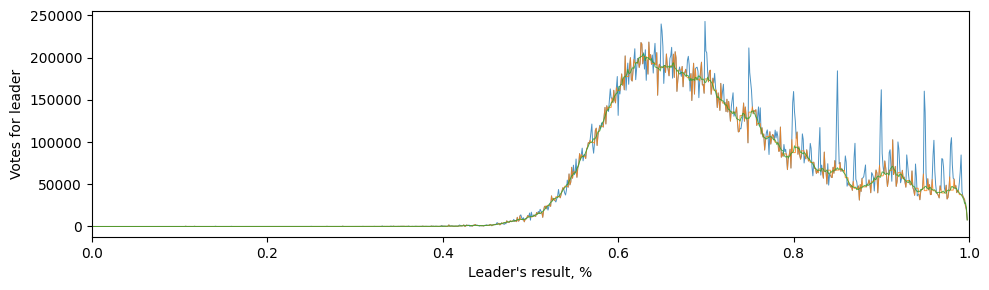

In [47]:
n,p,std = count_exceed_integer_votes(data, n_std = False, column = 'result_leader')

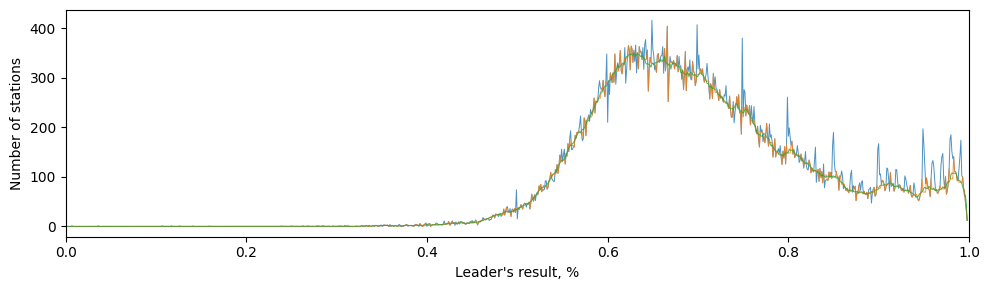

In [48]:
n,p,std = count_exceed_integer_votes(data, n_std = False, column = 'result_leader', stations = True)

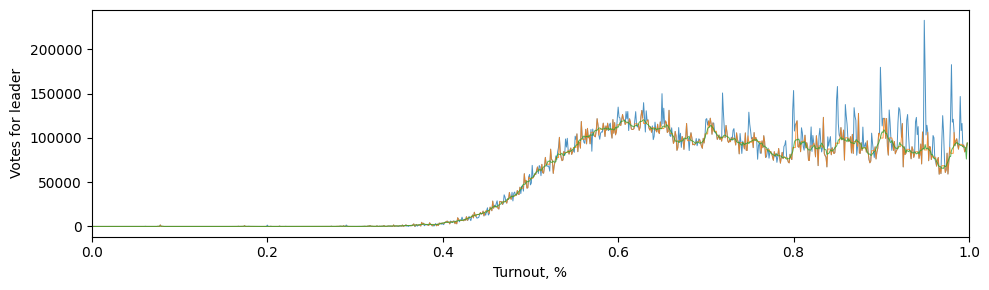

In [49]:
n,p,std = count_exceed_integer_votes(data, n_std = False, column = 'turnout')

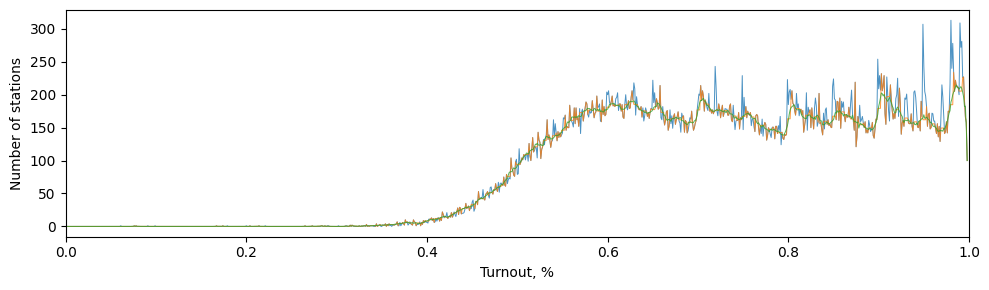

In [50]:
n,p,std = count_exceed_integer_votes(data, n_std = False, column = 'turnout', stations = True)

2000


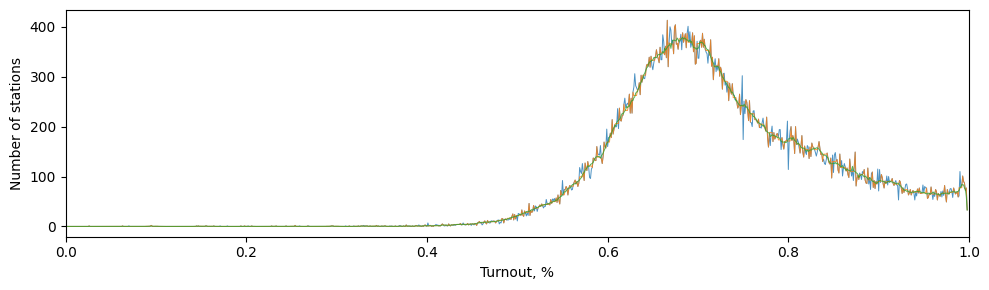

2003


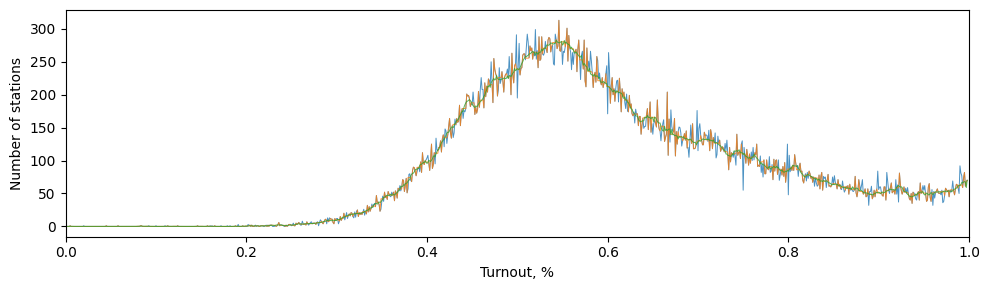

2004


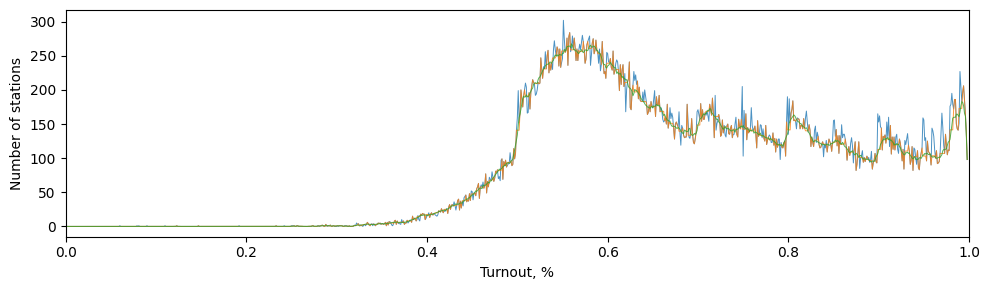

2007


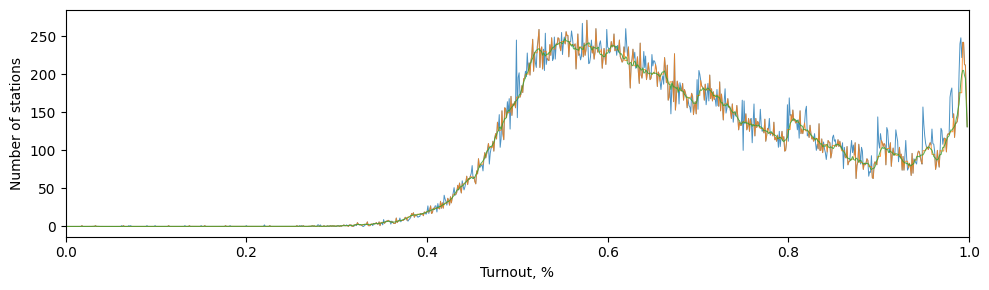

2008


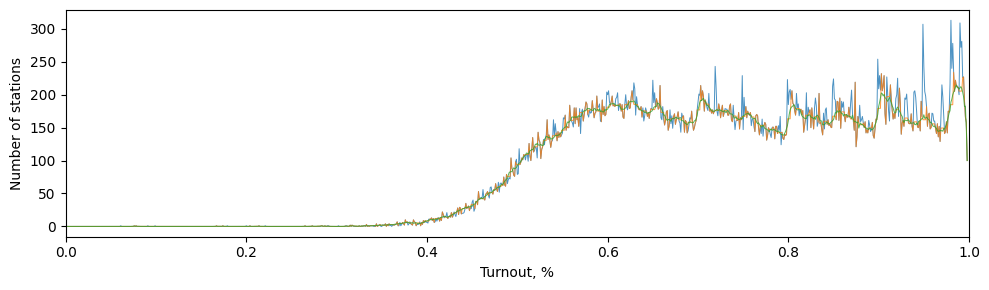

2011


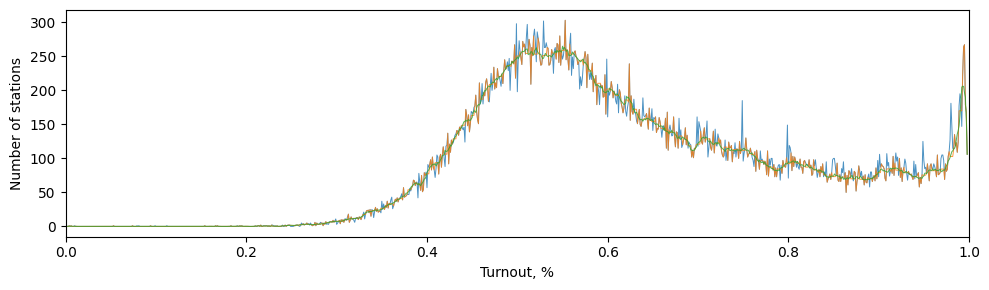

2012


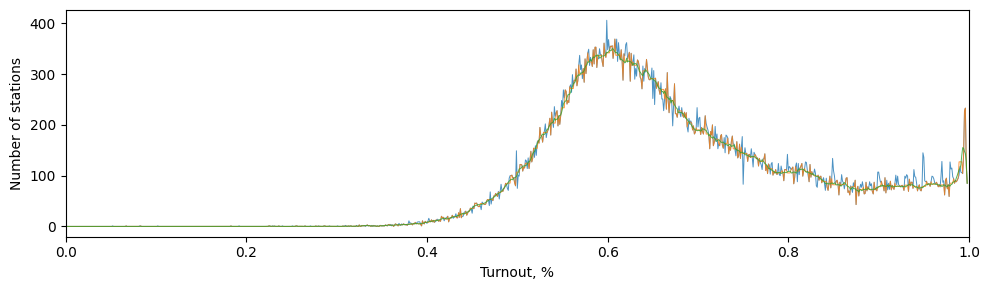

2016


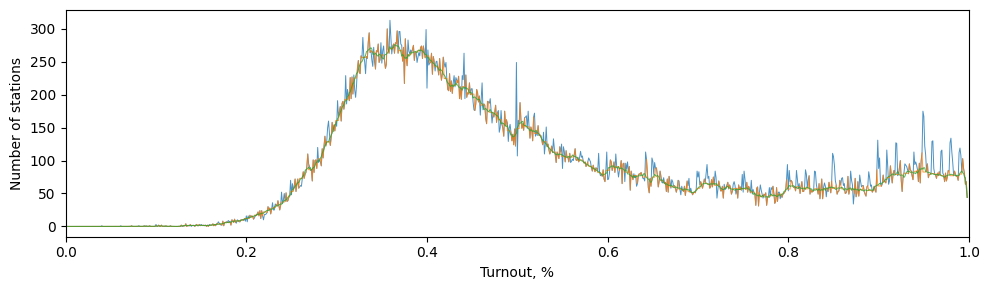

2018


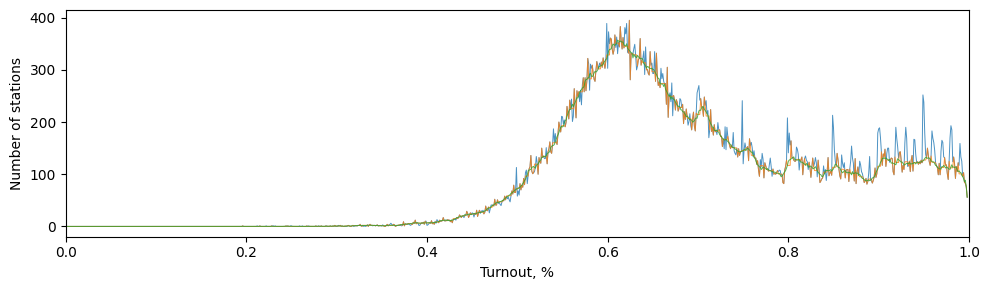

2020


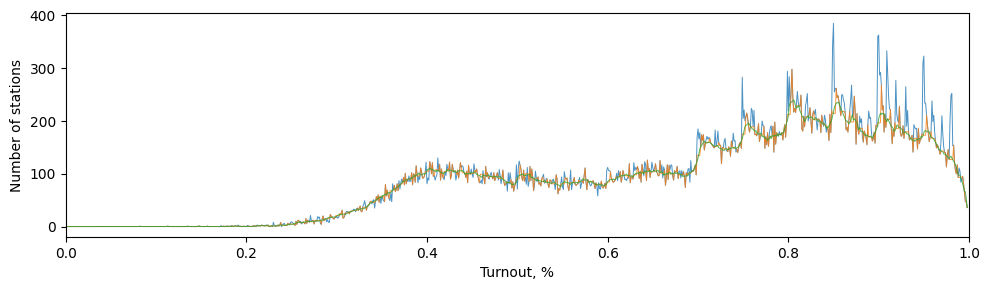

2021


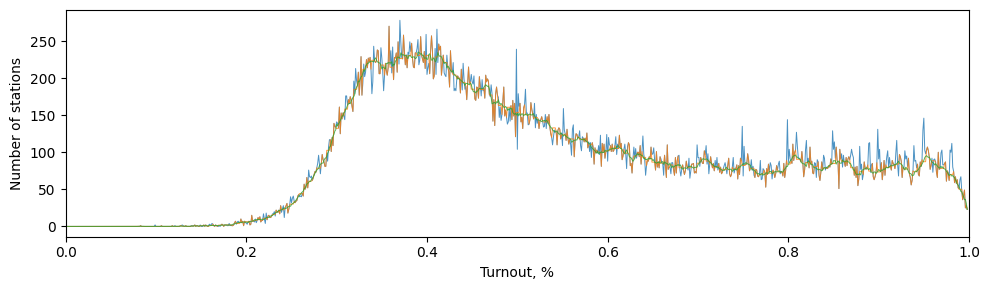

2024


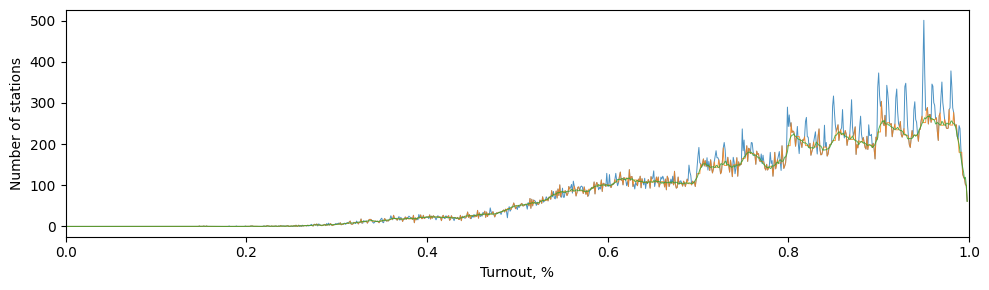

In [51]:
stations = []
n_percents = []
stds = []

for i,y in enumerate(years):

    print(y)
    data = data_years_filtered[i]
    n,p,std = count_exceed_integer_votes(data, n_std = False, only_significant = False, stations = True, column = 'turnout')
    # n_votes3.append(n)
    stations.append(n)
    n_percents.append(p)
    stds.append(std)

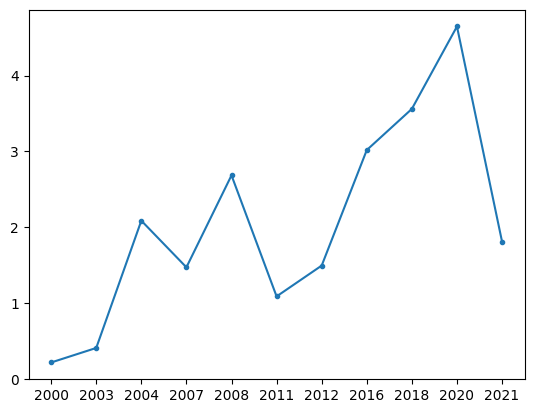

In [898]:
#percentage of stations with integer anomalies

plt.figure()
plt.plot(np.array(n_percents)*100, '.-')
t = plt.xticks(range(len(years)), years)

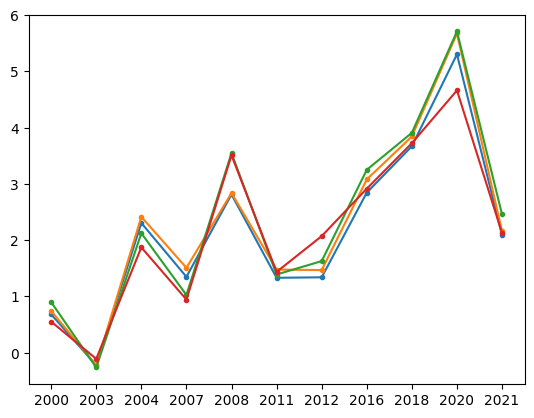

In [292]:
#percentage of stations with integer anomalies

plt.figure()
plt.plot(np.array(n_percents0)*100, '.-') #All stations
plt.plot(np.array(n_percents)*100, '.-') #Stations with >100 voters
plt.plot(np.array(n_percents1)*100, '.-') #Stations with >500 voters
plt.plot(np.array(n_percents2)*100, '.-') #Stations with >1000 voters
t = plt.xticks(range(len(years)), years)

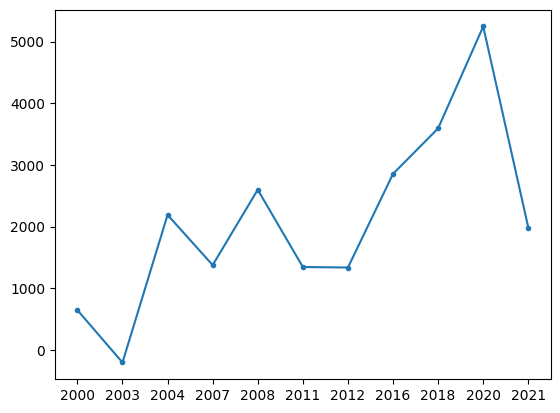

In [211]:
#Absolute number of stations

plt.figure()
plt.plot(np.array(stations), '.-')
t = plt.xticks(range(len(years)), years)

## Calculations

In [52]:
data = data_years_filtered[-1]

In [53]:
data_int = data[(np.mod(data['turnout'],0.01)>0.009)|(np.mod(data['turnout'],0.01)<0.002)|(np.mod(data['result_leader'],0.01)>0.009)|(np.mod(data['result_leader'],0.01)<0.002)]

In [54]:
data_notint = data[~((np.mod(data['turnout'],0.01)>0.009)|(np.mod(data['turnout'],0.01)<0.002)|(np.mod(data['result_leader'],0.01)>0.009)|(np.mod(data['result_leader'],0.01)<0.002))]

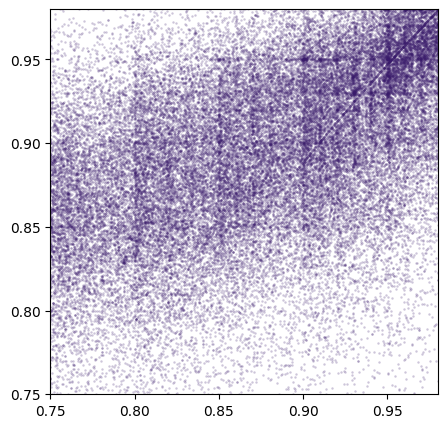

In [26]:
plt.figure(figsize = [5,5])
plt.scatter(data['turnout'], data['result_leader'], alpha = 0.25, s = 3, c = '#391A6B', edgecolors = None, linewidths = 0)
# plt.xlabel('Явка')
# plt.ylabel('Результат лидера')
plt.xlim([0.75,0.98])
plt.ylim([0.75,0.98])
plt.savefig('scatter_zoom.png', transparent=True)
# plt.legend(['Все участки'])

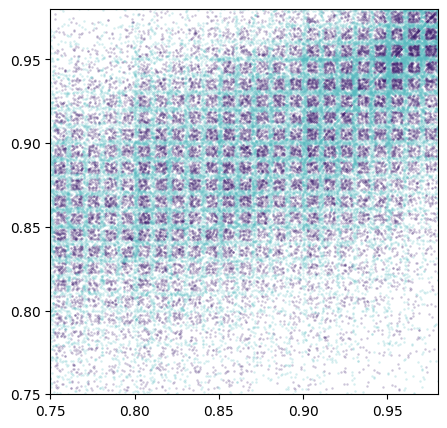

In [27]:
plt.figure(figsize = [5,5])
plt.scatter(data_notint['turnout'], data_notint['result_leader'], alpha = 0.25, s = 3, c = '#391A6B', edgecolors = None, linewidths = 0)
plt.scatter(data_int['turnout'], data_int['result_leader'], alpha = 0.25, s = 3, c = '#58BBC1', edgecolors = None, linewidths = 0) #'#391A6B'
# plt.xlabel('Явка')
# plt.ylabel('Результат лидера')
plt.xlim([0.75,0.98])
plt.ylim([0.75,0.98])
plt.savefig('scatter_zoom_colored.png', transparent=True)
# plt.legend(['"Честные" значения (нецелые проценты)', 'Значения, близкие к целым'])

In [55]:
coeff = (1-0.7**2)/0.7**2 #difference between light blue and dark blue areas on the pic above

In [56]:
n_votes0 = []
n_stations0 = []
percent_votes0 = []
percent_stations0 = []

for i,y in enumerate(years):
    
    data = data_years_filtered[i]
    data_int = data[((np.mod(data['turnout'],0.01)>0.009)|(np.mod(data['turnout'],0.01)<0.002)|(np.mod(data['result_leader'],0.01)>0.009)|(np.mod(data['result_leader'],0.01)<0.002))&(data['turnout']<0.99)&(data['result_leader']<0.99)]
    data_notint = data[(~((np.mod(data['turnout'],0.01)>0.009)|(np.mod(data['turnout'],0.01)<0.002)|(np.mod(data['result_leader'],0.01)>0.009)|(np.mod(data['result_leader'],0.01)<0.002)))&(data['turnout']<0.99)&(data['result_leader']<0.99)]
    n = np.sum(data_int['leader'])-np.sum(data_notint['leader'])*coeff
    n_votes0.append(n)
    percent_votes0.append(np.sum(data_int['leader'])/np.sum(data_int['total_voters']) - (np.sum(data_int['leader'])-n)/(np.sum(data_int['total_voters'])-n))
    ns = len(data_int)-len(data_notint)*coeff
    n_stations0.append(ns)
    percent_stations0.append(ns/len(data))

In [57]:
n_votes0

[321898.5102040805,
 218662.85714285634,
 2087848.897959184,
 1565187.8163265288,
 3682050.5102040805,
 1785877.6122448966,
 2242171.8367346935,
 2293285.8367346935,
 3082701.551020406,
 6868677.693877552,
 2285599.530612245,
 5925435.979591835]

In [58]:
for n in n_votes0:
    print(n)

321898.5102040805
218662.85714285634
2087848.897959184
1565187.8163265288
3682050.5102040805
1785877.6122448966
2242171.8367346935
2293285.8367346935
3082701.551020406
6868677.693877552
2285599.530612245
5925435.979591835


In [59]:
for n in percent_stations0:
    print(n*100)

0.40776420989375123
0.3767539060864698
2.5421196025221975
2.072903366991161
4.142129839663515
2.511991312564014
2.8764925271090416
4.048638868834845
3.838627931097163
7.611609832177574
2.8735424521850295
6.692514582305914


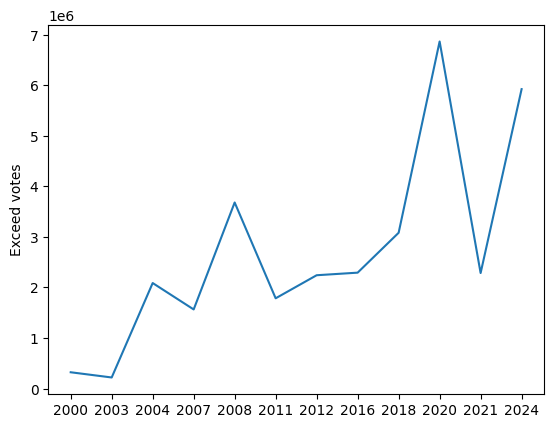

In [60]:
plt.figure()
plt.plot(n_votes0)
plt.ylabel('Exceed votes')
t = plt.xticks(range(len(years)), years)

Text(0, 0.5, 'Exceed stations')

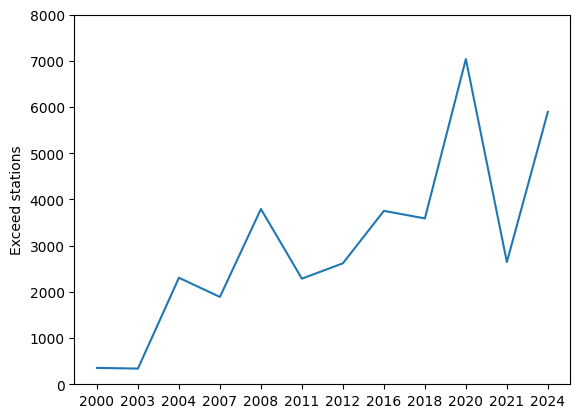

In [61]:
plt.figure()
plt.plot(n_stations0)
t = plt.xticks(range(len(years)), years)
plt.ylim([0,8000])
plt.ylabel('Exceed stations')

Text(0, 0.5, 'Percent of exceed stations')

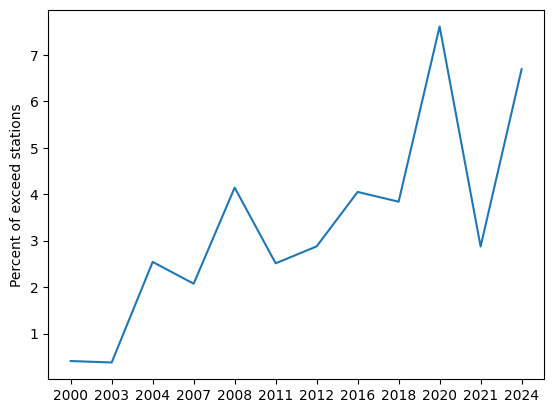

In [62]:
plt.figure()
plt.plot(np.array(percent_stations0)*100)
t = plt.xticks(range(len(years)), years)
plt.ylabel('Percent of exceed stations')

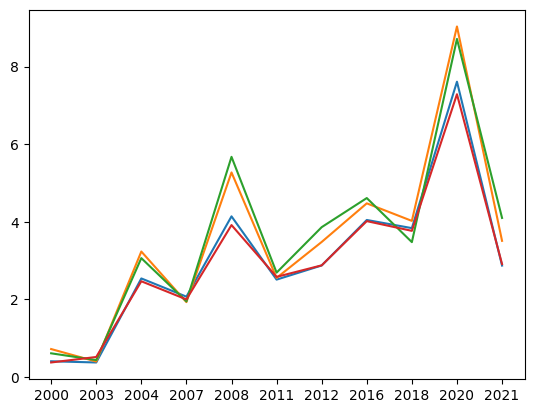

In [153]:
plt.figure()
plt.plot(np.array(percent_stations)*100) #only stations with 100+ voters
plt.plot(np.array(percent_stations1)*100) #only stations with 500+ voters
plt.plot(np.array(percent_stations2)*100) #only stations with 1000+ voters
plt.plot(np.array(percent_stations0)*100) #all stations
t = plt.xticks(range(len(years)), years)